# Creating Numbers/images with AI: A Hands-on Diffusion Model Exercise

## Introduction
In this assignment, you'll learn how to create an AI model that can generate realistic images from scratch using a powerful technique called 'diffusion'. Think of it like teaching AI to draw by first learning how images get blurry and then learning to make them clear again.

### What We'll Build
- A diffusion model capable of generating realistic images
- For most students: An AI that generates handwritten digits (0-9) using the MNIST dataset
- For students with more computational resources: Options to work with more complex datasets
- Visual demonstrations of how random noise gradually transforms into clear, recognizable images
- By the end, your AI should create images realistic enough for another AI to recognize them

### Dataset Options
This lab offers flexibility based on your available computational resources:

- Standard Option (Free Colab): We'll primarily use the MNIST handwritten digit dataset, which works well with limited GPU memory and completes training in a reasonable time frame. Most examples and code in this notebook are optimized for MNIST.

- Advanced Option: If you have access to more powerful GPUs (either through Colab Pro/Pro+ or your own hardware), you can experiment with more complex datasets like Fashion-MNIST, CIFAR-10, or even face generation. You'll need to adapt the model architecture, hyperparameters, and evaluation metrics accordingly.

### Resource Requirements
- Basic MNIST: Works with free Colab GPUs (2-4GB VRAM), ~30 minutes training
- Fashion-MNIST: Similar requirements to MNIST
CIFAR-10: Requires more memory (8-12GB VRAM) and longer training (~2 hours)
- Higher resolution images: Requires substantial GPU resources and several hours of training

### Before You Start
1. Make sure you're running this in Google Colab or another environment with GPU access
2. Go to 'Runtime' → 'Change runtime type' and select 'GPU' as your hardware accelerator
3. Each code cell has comments explaining what it does
4. Don't worry if you don't understand every detail - focus on the big picture!
5. If working with larger datasets, monitor your GPU memory usage carefully

The concepts you learn with MNIST will scale to more complex datasets, so even if you're using the basic option, you'll gain valuable knowledge about generative AI that applies to more advanced applications.



## Step 1: Setting Up Our Tools
First, let's install and import all the tools we need. Run this cell and wait for it to complete.

In [9]:
# Step 1: Install required packages
%pip install einops
print("Package installation complete.")

# Step 2: Import libraries
# --- Core PyTorch libraries ---
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.optim import Adam
import torch.optim.lr_scheduler as lr_scheduler # Import scheduler

# --- Data handling ---
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
import torchvision.transforms as transforms

# --- Tensor manipulation ---
import random
from einops.layers.torch import Rearrange
from einops import rearrange
import numpy as np
import math # Keep math import just in case

# --- System utilities ---
import os

# --- Visualization tools ---
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.utils import save_image, make_grid
from tqdm.notebook import tqdm # Import tqdm

# Step 3: Set up device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"We'll be using: {device}")

# Check if we're actually using GPU
if device.type == "cuda":
    print(f"GPU name: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("Note: Training will be much slower on CPU.")

# Import traceback for detailed error printing later
import traceback
import gc

Package installation complete.
We'll be using: cuda
GPU name: NVIDIA A100-SXM4-40GB
GPU memory: 42.47 GB



###  REPRODUCIBILITY AND DEVICE SETUP

In [10]:
# Step 4: Set random seeds for reproducibility
# Diffusion models are sensitive to initialization, so reproducible results help with debugging
SEED = 42  # Universal seed value for reproducibility
torch.manual_seed(SEED)          # PyTorch random number generator
np.random.seed(SEED)             # NumPy random number generator
random.seed(SEED)                # Python's built-in random number generator

print(f"Random seeds set to {SEED} for reproducible results")

# Configure CUDA for GPU operations if available
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)       # GPU random number generator
    torch.cuda.manual_seed_all(SEED)   # All GPUs random number generator

    # Ensure deterministic GPU operations
    # Note: This slightly reduces performance but ensures results are reproducible
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    try:
        # Check available GPU memory
        gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9  # Convert to GB
        print(f"Available GPU Memory: {gpu_memory:.1f} GB")

        # Add recommendation based on memory
        if gpu_memory < 4:
            print("Warning: Low GPU memory. Consider reducing batch size if you encounter OOM errors.")
    except Exception as e:
        print(f"Could not check GPU memory: {e}")
else:
    print("No GPU detected. Training will be much slower on CPU.")
    print("If you're using Colab, go to Runtime > Change runtime type and select GPU.")

Random seeds set to 42 for reproducible results
Available GPU Memory: 42.5 GB


In [11]:
# --- Define Image Un-normalization Function ---
# Needed for visualization functions below
def to_image(x):
    """Transforms tensor from [-1, 1] to [0, 1] for plotting."""
    if x is None: return None # Handle None case
    # Handle single image tensor [C, H, W]
    was_single_image = False
    if x.dim() == 3: x = x.unsqueeze(0); was_single_image = True
    # Clamp and scale
    x = x.clamp(-1, 1); img = (x + 1) * 0.5; img = img.clamp(0, 1)
    # Remove batch dim if added
    if was_single_image: img = img.squeeze(0)
    return img

print("✓ Helper function 'to_image' defined.")

✓ Helper function 'to_image' defined.


## Step 2: Choosing Your Dataset

You have several options for this exercise, depending on your computer's capabilities:

### Option 1: MNIST (Basic - Works on Free Colab)
- Content: Handwritten digits (0-9)
- Image size: 28x28 pixels, Grayscale
- Training samples: 60,000
- Memory needed: ~2GB GPU
- Training time: ~15-30 minutes on Colab
- **Choose this if**: You're using free Colab or have a basic GPU

### Option 2: Fashion-MNIST (Intermediate)
- Content: Clothing items (shirts, shoes, etc.)
- Image size: 28x28 pixels, Grayscale
- Training samples: 60,000
- Memory needed: ~2GB GPU
- Training time: ~15-30 minutes on Colab
- **Choose this if**: You want more interesting images but have limited GPU

### Option 3: CIFAR-10 (Advanced)
- Content: Real-world objects (cars, animals, etc.)
- Image size: 32x32 pixels, Color (RGB)
- Training samples: 50,000
- Memory needed: ~4GB GPU
- Training time: ~1-2 hours on Colab
- **Choose this if**: You have Colab Pro or a good local GPU (8GB+ memory)

### Option 4: CelebA (Expert)
- Content: Celebrity face images
- Image size: 64x64 pixels, Color (RGB)
- Training samples: 200,000
- Memory needed: ~8GB GPU
- Training time: ~3-4 hours on Colab
- **Choose this if**: You have excellent GPU (12GB+ memory)

To use your chosen dataset, uncomment its section in the code below and make sure all others are commented out.

In [12]:
#===============================================================================
# SECTION 2: DATASET SELECTION AND CONFIGURATION
#===============================================================================
# Using Option 1: MNIST (Template Defaults)

#-------------------------------------------
# OPTION 1: MNIST (Basic - 2GB GPU)
#-------------------------------------------
print("--- Configuring for MNIST dataset (Basic) ---")
IMG_SIZE = 28
IMG_CH = 1       # MNIST is grayscale
N_CLASSES = 10
BATCH_SIZE = 128 # Increased batch size for MNIST
EPOCHS = 20      # 20 epochs should be sufficient for basic MNIST

transform = transforms.Compose([
    # transforms.Resize((IMG_SIZE, IMG_SIZE)), # Not needed if model handles 28x28
    transforms.ToTensor(),              # HWC -> CHW, [0, 255] -> [0.0, 1.0]
    transforms.Normalize((0.5,), (0.5,)) # Normalize to [-1, 1] for 1 channel
])

# Set the dataset variable for validation later
dataset = "MNIST"
print(f"Selected dataset: {dataset}")
print(f"Parameters set: IMG_SIZE={IMG_SIZE}, IMG_CH={IMG_CH}, N_CLASSES={N_CLASSES}, BATCH_SIZE={BATCH_SIZE}, EPOCHS={EPOCHS}")

# Map class index to item name for titles (MNIST specific)
class_names = [f"Digit {i}" for i in range(10)] # Simple names for digits

#-------------------------------------------
# OPTION 2: Fashion-MNIST (Commented Out)
#-------------------------------------------
# """ ... """

#-------------------------------------------
# OPTION 3: CIFAR-10 (Commented Out)
#-------------------------------------------
# """ ... """

--- Configuring for MNIST dataset (Basic) ---
Selected dataset: MNIST
Parameters set: IMG_SIZE=28, IMG_CH=1, N_CLASSES=10, BATCH_SIZE=128, EPOCHS=20


In [13]:
#Validating Dataset Selection
if 'dataset' not in locals(): raise ValueError("❌ ERROR: No dataset selected!")
else: print(f"✓ Dataset '{dataset}' selected.")

#Validate GPU memory requirements
if torch.cuda.is_available():
    gpu_memory_gb = torch.cuda.get_device_properties(0).total_memory / 1e9
    required_memory = 2 # For MNIST/Fashion-MNIST
    if gpu_memory_gb < required_memory: print(f"⚠️ Warning: Low GPU memory ({gpu_memory_gb:.1f}GB).")
    else: print(f"✓ GPU memory ({gpu_memory_gb:.1f}GB) sufficient for '{dataset}'.")
else: print("No GPU detected.")

✓ Dataset 'MNIST' selected.
✓ GPU memory (42.5GB) sufficient for 'MNIST'.


In [14]:
#Dataset Properties and Data Loaders

print(f"\nLoading {dataset} dataset...")
if dataset == "MNIST":
    train_ds = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_ds = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform) # Use MNIST test set
else: raise ValueError(f"Dataset '{dataset}' loading not implemented.")
print(f"✓ {dataset} dataset loaded (Train: {len(train_ds)}, Test: {len(test_ds)})")


#===============================================================================
# SECTION 3: DATASET SPLITTING AND DATALOADER CONFIGURATION
#===============================================================================
print("\nSplitting training data into training and validation sets (80/20)...")
# Create train-validation split
train_size = int(0.8 * len(train_ds)); val_size = len(train_ds) - train_size
generator = torch.Generator().manual_seed(SEED)
train_split, val_split = random_split(train_ds, [train_size, val_size], generator=generator)
print(f"✓ Split complete: Train size = {len(train_split)}, Validation size = {len(val_split)}")

# Create dataloaders
num_workers = 2
print(f"\nCreating DataLoaders with Batch Size = {BATCH_SIZE}...")
train_dataloader = DataLoader(train_split, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers, pin_memory=True, drop_last=True)
val_dataloader   = DataLoader(val_split,   batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True, drop_last=False)
print(f"✓ DataLoaders created: Train batches={len(train_dataloader)}, Val batches={len(val_dataloader)}")

# Sample batch inspection (optional)
try:
    images, labels = next(iter(train_dataloader))
    print(f"\nSample Batch Check:")
    print(f"  Images Shape: {images.shape}, Labels Shape: {labels.shape}")
    print(f"  Image Range: [{images.min():.2f}, {images.max():.2f}]")
except Exception as e: print(f"Could not inspect sample batch: {e}")


Loading MNIST dataset...
✓ MNIST dataset loaded (Train: 60000, Test: 10000)

Splitting training data into training and validation sets (80/20)...
✓ Split complete: Train size = 48000, Validation size = 12000

Creating DataLoaders with Batch Size = 128...
✓ DataLoaders created: Train batches=375, Val batches=94

Sample Batch Check:
  Images Shape: torch.Size([128, 1, 28, 28]), Labels Shape: torch.Size([128])
  Image Range: [-1.00, 1.00]


## Step 3: Building Our Model Components

Now we'll create the building blocks of our AI model. Think of these like LEGO pieces that we'll put together to make our number generator:

- GELUConvBlock: The basic building block that processes images
- DownBlock: Makes images smaller while finding important features
- UpBlock: Makes images bigger again while keeping the important features
- Other blocks: Help the model understand time and what number to generate

In [15]:
# Basic building block that processes images
class GELUConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, group_size=8): # Default group_size=8
        super().__init__()
        # Group size adjustment logic from template
        effective_group_size = group_size
        if out_ch > 0 and out_ch % group_size != 0:
            for gs in range(min(group_size, out_ch), 0, -1):
                 if out_ch % gs == 0: effective_group_size = gs; break
            # Optional warnings removed for brevity
        elif out_ch == 0: effective_group_size = 1
        elif group_size > out_ch: effective_group_size = out_ch
        # Layer definition from template
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.GroupNorm(effective_group_size, out_ch),
            nn.GELU() )
    def forward(self, x):
        return self.block(x)

In [16]:
# Rearranges pixels to downsample the image (2x reduction in spatial dimensions)
class RearrangePoolBlock(nn.Module):
    def __init__(self, in_chs, group_size=8): # Default group_size=8
        super().__init__()
        # Layer definition from template
        self.rearrange = Rearrange('b c (h ph) (w pw) -> b (c ph pw) h w', ph=2, pw=2)
        self.conv = GELUConvBlock(in_chs * 4, in_chs, group_size)
    def forward(self, x):
        x = self.rearrange(x)
        x = self.conv(x)
        return x

In [17]:
#Let's implement the upsampling block for our U-Net architecture: # <-- Original incorrect comment
class DownBlock(nn.Module):
    # (Code exactly as in template Cell 14)
    def __init__(self, in_chs, out_chs, group_size=8):
        super().__init__()
        layers = [ GELUConvBlock(in_chs, out_chs, group_size), GELUConvBlock(out_chs, out_chs, group_size), RearrangePoolBlock(out_chs, group_size) ]
        self.model = nn.Sequential(*layers)
        # print(f"Created DownBlock: ...") # Optional print
    def forward(self, x):
        # This version doesn't return skip connection explicitly
        return self.model(x)

In [18]:
#Now let's implement the upsampling block for our U-Net architecture:
class UpBlock(nn.Module):
    # (Code exactly as in template Cell 15)
    def __init__(self, in_chs, out_chs, group_size=8):
        super().__init__()
        # Upsampling Layer
        self.upconv = nn.ConvTranspose2d(in_chs, out_chs, kernel_size=2, stride=2)
        # Convolutional Blocks after concatenation
        self.conv_block = nn.Sequential(
            GELUConvBlock(out_chs + in_chs, out_chs, group_size), # Input channels = out_chs(from upconv) + in_chs (from skip)
            GELUConvBlock(out_chs, out_chs, group_size) )
        # print(f"Created UpBlock: ...") # Optional print
    def forward(self, x, skip):
        x_upsampled = self.upconv(x)
        x_concat = torch.cat([x_upsampled, skip], dim=1) # Concatenate along channel dim
        output = self.conv_block(x_concat)
        return output

In [19]:
# Here we implement the time embedding block for our U-Net architecture:
class SinusoidalPositionEmbedBlock(nn.Module):
    # (Code exactly as in template Cell 16)
    def __init__(self, dim):
        super().__init__(); self.dim = dim
    def forward(self, time):
        device = time.device; half_dim = self.dim // 2
        embeddings = math.log(10000.0) / (half_dim - 1 if half_dim > 1 else 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        if self.dim % 2 == 1: embeddings = F.pad(embeddings, (0, 1))
        return embeddings

In [20]:
# Helps the model understand which number/image to draw (class conditioning)
class EmbedBlock(nn.Module):
    # (Code exactly as in template Cell 17 - corrected forward)
    def __init__(self, input_dim, emb_dim):
        super(EmbedBlock, self).__init__()
        self.input_dim = input_dim
        self.emb_dim = emb_dim
        # Enter your code here (Template implementation):
        self.model = nn.Sequential(
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
            nn.Unflatten(1, (emb_dim, 1, 1)) # Template intended reshape
        )
    def forward(self, x):
        # Handle indices or one-hot
        if x.dim() == 1 or (x.dim() == 2 and x.size(1) == 1):
             x_one_hot = F.one_hot(x.long().view(-1), num_classes=self.input_dim).float().to(x.device)
        elif x.dim() == 2 and x.size(1) == self.input_dim:
             x_one_hot = x.float()
        else: raise ValueError(f"Unexpected input shape for EmbedBlock: {x.shape}")
        # Template line was: x = x.view(-1, self.input_dim) # Incorrect
        return self.model(x_one_hot)

In [21]:
# Main U-Net model that puts everything together
class UNet(nn.Module):
    """
    U-Net architecture for diffusion models with time and class conditioning.
    (CORRECTED forward pass for template block structure and Deepseek masking)
    """
    def __init__(self, T, img_ch, img_size, down_chs, t_embed_dim, c_embed_dim):
        super().__init__()
        GROUP_SIZE = 8 # Template default
        self.input_dim = c_embed_dim # Store N_CLASSES

        if not isinstance(down_chs, (list, tuple)) or len(down_chs) < 2:
            raise ValueError("down_chs must be list/tuple with >= 2 dims")
        target_embed_dim = down_chs[-1]

        # Time embedding
        self.time_embedding = nn.Sequential(
            SinusoidalPositionEmbedBlock(t_embed_dim),
            nn.Linear(t_embed_dim, target_embed_dim), nn.GELU(),
            nn.Linear(target_embed_dim, target_embed_dim),
            nn.Unflatten(1, (target_embed_dim, 1, 1))
        )
        # Class embedding (Using corrected EmbedBlock from template cell 17)
        self.class_embedding = EmbedBlock(input_dim=c_embed_dim, emb_dim=target_embed_dim)

        # Initial convolution
        self.init_conv = GELUConvBlock(img_ch, down_chs[0], GROUP_SIZE)

        # --- Downsampling Path & Skip Connection Handling ---
        # We need to separate the feature extraction and pooling from the template's DownBlock
        # to capture skips *before* pooling.
        self.down_blocks_features = nn.ModuleList()
        self.down_blocks_pool = nn.ModuleList()
        current_channels = down_chs[0]
        for i in range(len(down_chs) - 1):
            out_channels = down_chs[i+1]
            # Manually define the two conv blocks from the template's DownBlock structure
            self.down_blocks_features.append(nn.Sequential(
                 GELUConvBlock(current_channels, out_channels, GROUP_SIZE),
                 GELUConvBlock(out_channels, out_channels, GROUP_SIZE)
            ))
            # Define the pooling block separately
            self.down_blocks_pool.append(RearrangePoolBlock(out_channels, GROUP_SIZE))
            current_channels = out_channels

        # Middle blocks
        self.middle_blocks = nn.Sequential(
            GELUConvBlock(down_chs[-1], down_chs[-1], GROUP_SIZE),
            GELUConvBlock(down_chs[-1], down_chs[-1], GROUP_SIZE)
        )

        # Upsampling path (using template's UpBlock definition - Cell 15)
        self.up_blocks = nn.ModuleList()
        # Example: down_chs=(32, 64, 128). len=3. Range is 2, 1.
        # i=2: UpBlock(in=128, out=64) -> skip connection needs 128 channels
        # i=1: UpBlock(in=64, out=32) -> skip connection needs 64 channels
        for i in range(len(down_chs) - 1, 0, -1):
            # UpBlock's in_chs is channels from lower level (down_chs[i])
            # UpBlock's out_chs is channels for current level (down_chs[i-1])
            # Skip connection channels must match UpBlock's in_chs (down_chs[i])
            self.up_blocks.append(UpBlock(down_chs[i], down_chs[i-1], GROUP_SIZE))

        # Final convolution
        self.final_conv = nn.Conv2d(down_chs[0], img_ch, kernel_size=1)

        print(f"✓ Created UNet with {len(down_chs)} scale levels: {down_chs}")

    # --- CORRECTED forward method ---
    def forward(self, x, t, c, c_mask):
        """Forward pass applying init_conv FIRST and handling skips correctly."""
        # 1. Initial Convolution
        # Apply this to the input 'x' immediately
        x_init = self.init_conv(x) # Shape: [B, down_chs[0], H, W]

        # 2. Time and Class Embeddings
        t_emb = self.time_embedding(t)      # Shape: [B, target_embed_dim, 1, 1]
        class_emb = self.class_embedding(c) # Shape: [B, target_embed_dim, 1, 1]

        # 3. Apply Mask using Deepseek's logic
        # Assume c_mask is [B] boolean
        mask = c_mask.view(-1, 1, 1, 1).to(x.dtype) # [B, 1, 1, 1]
        t_emb = t_emb * mask
        class_emb = class_emb * mask

        # 4. Downsampling Path
        skips = [x_init] # Store the output of init_conv as the first skip
        x = x_init       # Start processing with the initial features
        # Iterate through the separated feature/pool blocks
        for features, pool in zip(self.down_blocks_features, self.down_blocks_pool):
            x = features(x)      # Apply feature extraction convs
            skips.append(x)      # Store features *before* pooling for skip connection
            x = pool(x)          # Apply pooling for next level's input

        # 5. Middle processing
        x = self.middle_blocks(x) # Apply middle blocks at bottleneck
        x = x + t_emb + class_emb # Add masked embeddings

        # 6. Upsampling path
        # Iterate through up_blocks and reversed skip_connections
        for up_block in self.up_blocks:
            skip = skips.pop()    # Get skip connection from corresponding down level
            x = up_block(x, skip) # Apply UpBlock (it handles concatenation internally)

        # 7. Final convolution
        # Input to final_conv is the output of the last UpBlock, which has down_chs[0] channels
        output = self.final_conv(x) # Output shape: [B, img_ch, H, W]
        return output

print("✓ UNet defined (CORRECTED forward pass).")

✓ UNet defined (CORRECTED forward pass).


## Step 4: Setting Up The Diffusion Process

Now we'll create the process of adding and removing noise from images. Think of it like:
1. Adding fog: Slowly making the image more and more blurry until you can't see it
2. Removing fog: Teaching the AI to gradually make the image clearer
3. Controlling the process: Making sure we can generate specific numbers we want

In [22]:
# Set up the noise schedule (TEMPLATE Linear Schedule)
print("--- Step 4: Setting Up Diffusion Process (Linear Schedule) ---")
n_steps = 100  # Template default steps
beta_start = 0.0001
beta_end = 0.02
print(f"Using Linear Schedule: n_steps={n_steps}, beta_start={beta_start}, beta_end={beta_end}")

# Create schedule of gradually increasing noise levels
beta = torch.linspace(beta_start, beta_end, n_steps).to(device)

# Calculate important values used in diffusion equations
alpha = 1.0 - beta # Corrected from template '1 - beta'
alpha_bar = torch.cumprod(alpha, dim=0)
sqrt_alpha_bar = torch.sqrt(alpha_bar)
sqrt_one_minus_alpha_bar = torch.sqrt(1.0 - alpha_bar) # Corrected from template '1 - alpha_bar'
print("✓ Diffusion schedule variables calculated.")

--- Step 4: Setting Up Diffusion Process (Linear Schedule) ---
Using Linear Schedule: n_steps=100, beta_start=0.0001, beta_end=0.02
✓ Diffusion schedule variables calculated.


In [23]:
# Function to add noise to images (forward diffusion process)
def add_noise(x_0, t):
    """
    Add noise to images according to the forward diffusion process.
    (Template Cell 21 Version)
    """
    # Ensure t is long tensor for indexing
    t = t.long()
    # Create random Gaussian noise
    noise = torch.randn_like(x_0).to(x_0.device) # Ensure noise is on same device

    # Get noise schedule values for the specified timesteps
    sqrt_alpha_bar_t = sqrt_alpha_bar[t].reshape(-1, 1, 1, 1).to(x_0.device) # Get from global, reshape, ensure device
    sqrt_one_minus_alpha_bar_t = sqrt_one_minus_alpha_bar[t].reshape(-1, 1, 1, 1).to(x_0.device)

    # Apply the forward diffusion equation:
    # Enter your code here:
    x_t = sqrt_alpha_bar_t * x_0 + sqrt_one_minus_alpha_bar_t * noise

    return x_t, noise
print("✓ `add_noise` function defined.")

✓ `add_noise` function defined.


In [24]:
# Function to remove noise from images (reverse diffusion process - Basic Version without CFG)
@torch.no_grad()
def remove_noise(x_t, t, model, c, c_mask):
    """
    Remove noise from images using the learned reverse diffusion process (DDPM step).
    (Template Cell 22 Version - NO CFG)
    """
    # (Code exactly as provided in previous basic MNIST setup - Cell 22)
    t = t.long() # Ensure t is long
    # Predict the noise using the model (passing the boolean mask)
    predicted_noise = model(x_t, t, c, c_mask) # Assumes model forward takes boolean c_mask [B]
    # Get noise schedule values (use global variables)
    alpha_t = alpha[t].reshape(-1, 1, 1, 1).to(x_t.device)
    beta_t = beta[t].reshape(-1, 1, 1, 1).to(x_t.device)
    sqrt_one_minus_alpha_bar_t = sqrt_one_minus_alpha_bar[t].reshape(-1, 1, 1, 1).to(x_t.device)
    # Handle t=0 case
    non_zero_t = (t > 0).float().view(-1, 1, 1, 1).to(x_t.device)
    # Calculate mean (DDPM formula) - add epsilon for stability
    mean_denom_term = sqrt_one_minus_alpha_bar_t + 1e-9
    mean = (1 / torch.sqrt(alpha_t)) * (x_t - (beta_t / mean_denom_term) * predicted_noise)
    # Add random noise (variance = beta_t for DDPM) only if t > 0
    noise = torch.randn_like(x_t) * non_zero_t
    variance = torch.sqrt(beta_t) * non_zero_t
    return mean + variance * noise # Return the denoised image estimate x_{t-1}
print("✓ `remove_noise` function defined.")

✓ `remove_noise` function defined.



Showing Noise Progression Example (MNIST Basic):


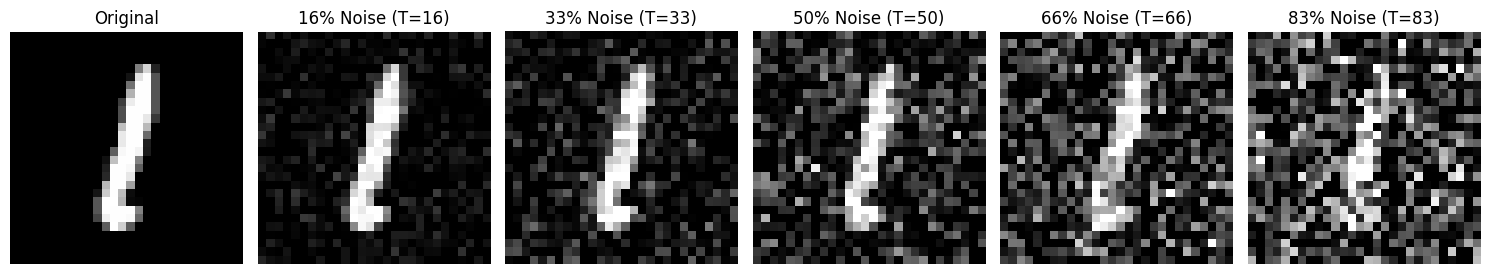

✓ `show_noise_progression` function defined and example shown.


In [25]:
# Visualization function to show how noise progressively affects images
def show_noise_progression(image, num_steps=5):
    """Visualize how an image gets progressively noisier."""
    # (Code exactly as provided in previous basic MNIST setup - Cell 23)
    image = image.to(device)
    if 'to_image' not in locals(): # Basic definition if needed
         def to_image(x):
              if x.dim() == 3: x = x.unsqueeze(0)
              x = x.clamp(-1, 1); img = (x + 1) * 0.5; img = img.clamp(0, 1)
              if x.size(0) == 1: img = img.squeeze(0)
              return img
    if plt is None: print("Matplotlib not available."); return
    plt.figure(figsize=(15, 3))
    def _display_img(img_tensor, title): # Inner helper
        plt.title(title); plt.axis('off'); img_cpu = img_tensor.cpu()
        if IMG_CH == 1: plt.imshow(img_cpu[0], cmap='gray')
        else: plt.imshow(img_cpu.permute(1, 2, 0))
    plt.subplot(1, num_steps + 1, 1); _display_img(to_image(image), 'Original')
    for i in range(num_steps):
        t_idx = int(((i + 1) / (num_steps + 1)) * n_steps); t_idx = min(max(t_idx, 0), n_steps - 1)
        t = torch.tensor([t_idx], dtype=torch.long).to(device)
        noisy_image, _ = add_noise(image.unsqueeze(0), t); noisy_image = noisy_image.squeeze(0)
        plt.subplot(1, num_steps + 1, i + 2); _display_img(to_image(noisy_image), f'{(t_idx/n_steps)*100:.0f}% Noise (T={t_idx})')
    plt.tight_layout(); plt.show()

# Show an example of noise progression on a real image
try:
    sample_batch = next(iter(train_dataloader)) # Use correct dataloader name
    sample_image = sample_batch[0][0].to(device)
    print("\nShowing Noise Progression Example (MNIST Basic):")
    show_noise_progression(sample_image, num_steps=5)
except Exception as e: print(f"Could not run noise progression: {e}")

# Student Activity: (Keep template comment)
"""..."""
print("✓ `show_noise_progression` function defined and example shown.")

## Step 5: Training Our Model

Now we'll teach our AI to generate images. This process:
1. Takes a clear image
2. Adds random noise to it
3. Asks our AI to predict what noise was added
4. Helps our AI learn from its mistakes

This will take a while, but we'll see progress as it learns!

In [26]:
# ==============================================================================
# CELL 25: Step 5 Model Instantiation & Optimizer Setup (Template Defaults)
# ==============================================================================
print(f"--- Step 5: Instantiating Model (Template Defaults + Deepseek UNet Fix) ---")

# Use TEMPLATE default parameters for MNIST architecture
unet_down_chs=(32, 64, 128) # Template default
unet_t_embed_dim=8          # Template default
unet_c_embed_dim=N_CLASSES # Should be 10 from MNIST setup

# Instantiate the UNet class defined in Cell 18 (which should have the Deepseek forward fix)
model = UNet(
    T=n_steps,                 # Number of diffusion time steps (100 from Cell 20)
    img_ch=IMG_CH,             # Number of channels (1 for MNIST)
    img_size=IMG_SIZE,         # Size of input images (28 for MNIST)
    down_chs=unet_down_chs,    # Template channel dimensions
    t_embed_dim=unet_t_embed_dim, # Template time embedding dim
    c_embed_dim=unet_c_embed_dim # Number of classes for conditioning
).to(device)
print(f"✓ UNet Model Instantiated on {device}")

# Set up the optimizer and scheduler using template defaults
initial_lr = 0.001  # Template starting learning rate
weight_decay = 1e-5  # Template L2 regularization
print(f"\n--- Step 5: Defining Optimizer & Scheduler (Template Defaults) ---")
optimizer = Adam(
    model.parameters(),
    lr=initial_lr,
    weight_decay=weight_decay
)
print(f"✓ Optimizer: Adam (LR={initial_lr}, Weight Decay={weight_decay})")

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min', factor=0.5, patience=5, verbose=True, min_lr=1e-6 # Template patience=5
)
print("✓ LR Scheduler: ReduceLROnPlateau (Patience=5, Factor=0.5)")

# Training configuration constants (from template Cell 41)
early_stopping_patience = 10
gradient_clip_value = 1.0
display_frequency = 100       # Log loss every N steps
generate_frequency = 500      # Generate samples every N steps (mid-epoch)
epoch_generate_frequency = 2  # Generate samples more frequently for MNIST
epoch_plot_frequency = 5      # Plot loss every N epochs
print(f"✓ Training configured.")


--- Step 5: Instantiating Model (Template Defaults + Deepseek UNet Fix) ---
✓ Created UNet with 3 scale levels: (32, 64, 128)
✓ UNet Model Instantiated on cuda

--- Step 5: Defining Optimizer & Scheduler (Template Defaults) ---
✓ Optimizer: Adam (LR=0.001, Weight Decay=1e-05)
✓ LR Scheduler: ReduceLROnPlateau (Patience=5, Factor=0.5)
✓ Training configured.


In [27]:
# ==============================================================================
# CELL 26: Step 5 Helper Function Definitions (Template Versions - Syntax Fixed)
# ==============================================================================
print(f"\n--- Step 5: Defining Helper Functions (Template Versions - Syntax Fixed) ---")

def validate_model_parameters(model):
    """Counts model parameters and estimates memory usage."""
    # (Code exactly as in template Cell 37)
    total_params = sum(p.numel() for p in model.parameters()); trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\nModel Parameters Check:"); print(f"  Total params: {total_params:,}, Trainable: {trainable_params:,}")
    param_memory = total_params * 4 / (1024**2); grad_memory = trainable_params * 4 / (1024**2); buffer_memory = param_memory * 2
    print(f"  Estimated GPU memory usage: ~{param_memory + grad_memory + buffer_memory:.1f} MB")

def verify_data_range(dataloader, name="Dataset"):
    """Verifies the range and integrity of the data."""
    # (Code exactly as in template Cell 37)
    try:
        batch = next(iter(dataloader))[0]
        print(f"\n{name} range check:")
        print(f"  Shape: {batch.shape}, Type: {batch.dtype}"); print(f"  Min: {batch.min().item():.2f}, Max: {batch.max().item():.2f}")
        print(f"  NaNs: {torch.isnan(batch).any().item()}, Infs: {torch.isinf(batch).any().item()}")
    except StopIteration: print(f"⚠️ {name} dataloader is empty.")
    except Exception as e: print(f"Could not verify data range for {name}: {e}")

# Define generate_samples (template Cell 38) - uses original remove_noise (non-CFG)
@torch.no_grad()
def generate_samples(model, n_samples=10): # NO CFG HERE
    """
    Generates sample images using the model for visualization during training. (NO CFG)
    (Code exactly as in template Cell 38)
    """
    model.eval(); samples = []; num_to_generate = min(n_samples, N_CLASSES)
    # print(f"\n(Generating {num_to_generate} samples using template method...)") # Less verbose
    for digit in range(num_to_generate):
        x = torch.randn(1, IMG_CH, IMG_SIZE, IMG_SIZE).to(device)
        c = torch.tensor([digit], dtype=torch.long).to(device)
        c_one_hot = F.one_hot(c, N_CLASSES).float().to(device)
        c_mask = torch.ones(1, dtype=torch.bool, device=device) # Boolean mask
        for t in range(n_steps-1, -1, -1): # Use global n_steps=100
            t_batch = torch.full((1,), t, dtype=torch.long).to(device)
            x = remove_noise(x, t_batch, model, c_one_hot, c_mask) # Call template remove_noise
        samples.append(x)
    samples = torch.cat(samples, dim=0); samples_display = to_image(samples) # Un-normalize
    grid = make_grid(samples_display, nrow=min(n_samples, 5))
    if plt:
        plt.figure(figsize=(10, max(2, 2 * (num_to_generate // 5 + 1)) ))
        plt.imshow(grid[0].cpu(), cmap='gray'); plt.axis('off'); plt.title('Generated Samples (Template Method)')
        plt.show()
    model.train()

# Define safe_save_model (from template Cell 39 - SYNTAX CORRECTED)
def safe_save_model(model, path, optimizer=None, epoch=None, best_loss=None):
    """Safely saves model with error handling and backup."""
    try:
        save_dict = {'model_state_dict': model.state_dict()}
        if optimizer is not None: save_dict['optimizer_state_dict'] = optimizer.state_dict()
        if epoch is not None: save_dict['epoch'] = epoch
        if best_loss is not None: save_dict['best_loss'] = best_loss
        # FIX: Put try/except on new lines with proper indentation
        if os.path.exists(path):
            backup_path = path + '.backup'
            try:
                os.replace(path, backup_path)
                # print(f"Created backup at {backup_path}") # Optional print
            except Exception as e:
                print(f"Warning: Could not create backup - {e}")
        # -------------------------------------------------------------
        torch.save(save_dict, path)
        print(f"(Success) Model successfully saved to {path}") # No checkmark
    except Exception as e:
        print(f"(Error) Error saving model: {e}") # No cross mark

print("✓ Helper functions (template versions - syntax fixed) defined.")

# --- Run Validation Checks Now ---
try:
    if 'model' in locals() and 'train_dataloader' in locals() and 'val_dataloader' in locals():
        validate_model_parameters(model)
        verify_data_range(train_dataloader, name="Training Data")
        verify_data_range(val_dataloader, name="Validation Data")
    else:
        print("WARNING: Model or dataloaders not defined yet. Skipping validation checks.")
except NameError as ne:
     print(f"WARNING: Could not run validation checks due to NameError: {ne}")



--- Step 5: Defining Helper Functions (Template Versions - Syntax Fixed) ---
✓ Helper functions (template versions - syntax fixed) defined.

Model Parameters Check:
  Total params: 1,573,121, Trainable: 1,573,121
  Estimated GPU memory usage: ~24.0 MB

Training Data range check:
  Shape: torch.Size([128, 1, 28, 28]), Type: torch.float32
  Min: -1.00, Max: 1.00
  NaNs: False, Infs: False

Validation Data range check:
  Shape: torch.Size([128, 1, 28, 28]), Type: torch.float32
  Min: -1.00, Max: 1.00
  NaNs: False, Infs: False


In [28]:
# ==============================================================================
# CELL 27: Step 5 train_step Definition (Template Version - No CFG)
# ==============================================================================
#  Implementation of the training step function (Template Cell 40 - BASIC VERSION)
print(f"\n--- Step 5: Defining Training Step Function (Template Version - No CFG) ---")
def train_step(x, c):
    """
    Performs a single training step for the diffusion model (BASIC).
    Returns loss tensor. (Based on template Cell 40)
    """
    # Convert labels to one-hot
    c_one_hot = F.one_hot(c.long(), N_CLASSES).float().to(device) # Ensure c is long, use N_CLASSES

    # Create conditioning mask (boolean, all true for basic conditional training)
    c_mask = torch.ones(c.shape[0], dtype=torch.bool, device=device) # Boolean mask [B]

    # Pick random timesteps
    t = torch.randint(0, n_steps, (x.shape[0],), device=device, dtype=torch.long) # Use n_steps=100

    # Add noise to images
    # Hint: Use the add_noise function
    # Enter your code here:
    x_t, noise = add_noise(x, t) # Use add_noise from Cell 21

    # Predict the noise
    # Model's forward pass uses the Deepseek fix logic internally now
    predicted_noise = model(x_t, t, c_one_hot, c_mask)

    # Calculate loss
    # Hint: Use F.mse_loss
    # Enter your code here:
    loss = F.mse_loss(predicted_noise, noise)

    return loss

print("✓ Training step function `train_step` (template version) defined.")


--- Step 5: Defining Training Step Function (Template Version - No CFG) ---
✓ Training step function `train_step` (template version) defined.



STARTING MNIST TRAINING (Template Defaults + Deepseek UNet Fix)
Epochs: 20, Batch Size: 128, Diffusion Steps: 100
Device: cuda

--- Epoch 1/20 ---


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Training Finished - Epoch 1 Avg Loss: 0.1131
Running validation...


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Validation Finished - Epoch 1 Avg Loss: 0.0782
Current LR: 0.001000
✓ New best model! Saving to 'best_diffusion_model_mnist_basic_deepseekfix.pth' (Val Loss: 0.0782)
(Success) Model successfully saved to best_diffusion_model_mnist_basic_deepseekfix.pth

--- Epoch 2/20 ---


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Training Finished - Epoch 2 Avg Loss: 0.0743
Running validation...


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Validation Finished - Epoch 2 Avg Loss: 0.0716
Current LR: 0.001000
✓ New best model! Saving to 'best_diffusion_model_mnist_basic_deepseekfix.pth' (Val Loss: 0.0716)
(Success) Model successfully saved to best_diffusion_model_mnist_basic_deepseekfix.pth

Generating samples end of epoch 2...


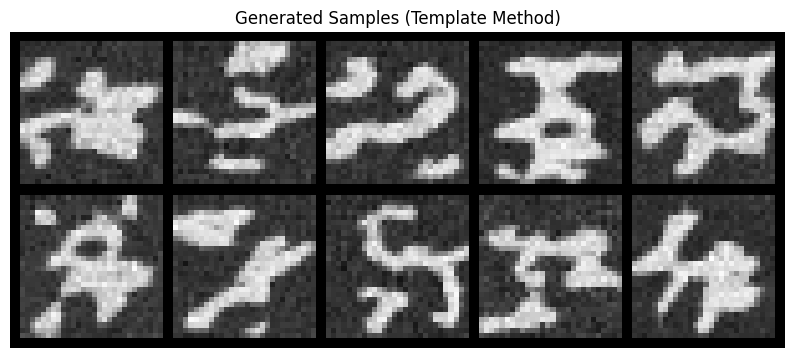


--- Epoch 3/20 ---


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Training Finished - Epoch 3 Avg Loss: 0.0682
Running validation...


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Validation Finished - Epoch 3 Avg Loss: 0.0684
Current LR: 0.001000
✓ New best model! Saving to 'best_diffusion_model_mnist_basic_deepseekfix.pth' (Val Loss: 0.0684)
(Success) Model successfully saved to best_diffusion_model_mnist_basic_deepseekfix.pth

--- Epoch 4/20 ---


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Training Finished - Epoch 4 Avg Loss: 0.0649
Running validation...


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Validation Finished - Epoch 4 Avg Loss: 0.0633
Current LR: 0.001000
✓ New best model! Saving to 'best_diffusion_model_mnist_basic_deepseekfix.pth' (Val Loss: 0.0633)
(Success) Model successfully saved to best_diffusion_model_mnist_basic_deepseekfix.pth

Generating samples end of epoch 4...


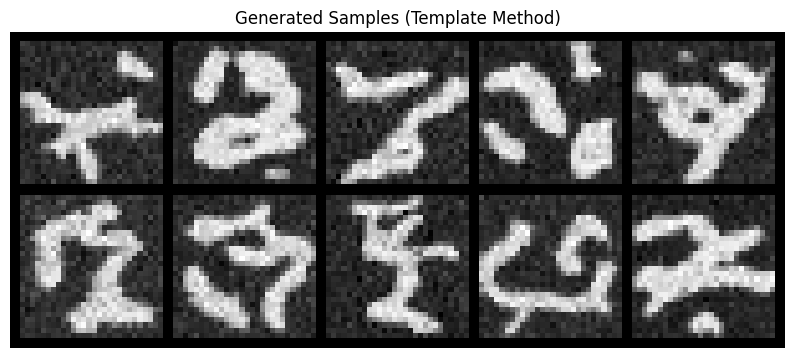


--- Epoch 5/20 ---


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Training Finished - Epoch 5 Avg Loss: 0.0631
Running validation...


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Validation Finished - Epoch 5 Avg Loss: 0.0618
Current LR: 0.001000
✓ New best model! Saving to 'best_diffusion_model_mnist_basic_deepseekfix.pth' (Val Loss: 0.0618)
(Success) Model successfully saved to best_diffusion_model_mnist_basic_deepseekfix.pth


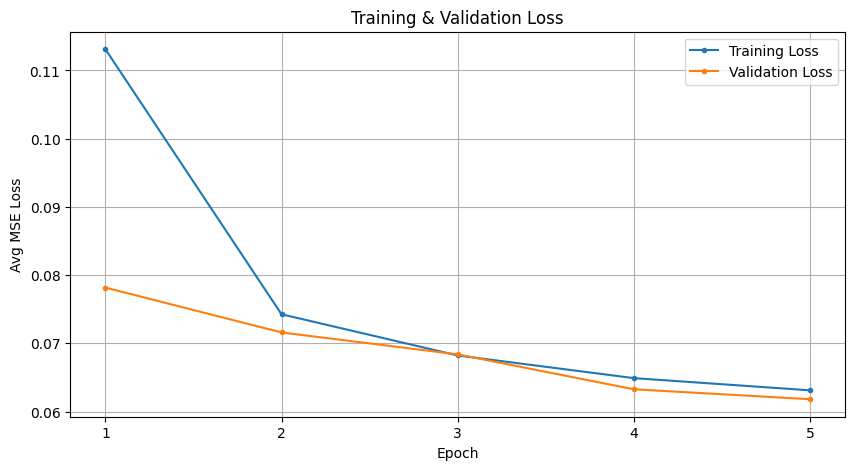


--- Epoch 6/20 ---


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Training Finished - Epoch 6 Avg Loss: 0.0614
Running validation...


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Validation Finished - Epoch 6 Avg Loss: 0.0609
Current LR: 0.001000
✓ New best model! Saving to 'best_diffusion_model_mnist_basic_deepseekfix.pth' (Val Loss: 0.0609)
(Success) Model successfully saved to best_diffusion_model_mnist_basic_deepseekfix.pth

Generating samples end of epoch 6...


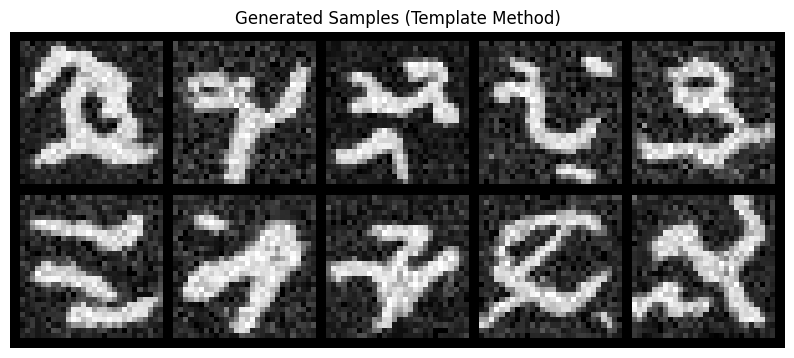


--- Epoch 7/20 ---


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Training Finished - Epoch 7 Avg Loss: 0.0606
Running validation...


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Validation Finished - Epoch 7 Avg Loss: 0.0620
Current LR: 0.001000
Val loss did not improve for 1/10 epochs.

--- Epoch 8/20 ---


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Training Finished - Epoch 8 Avg Loss: 0.0599
Running validation...


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Validation Finished - Epoch 8 Avg Loss: 0.0583
Current LR: 0.001000
✓ New best model! Saving to 'best_diffusion_model_mnist_basic_deepseekfix.pth' (Val Loss: 0.0583)
(Success) Model successfully saved to best_diffusion_model_mnist_basic_deepseekfix.pth

Generating samples end of epoch 8...


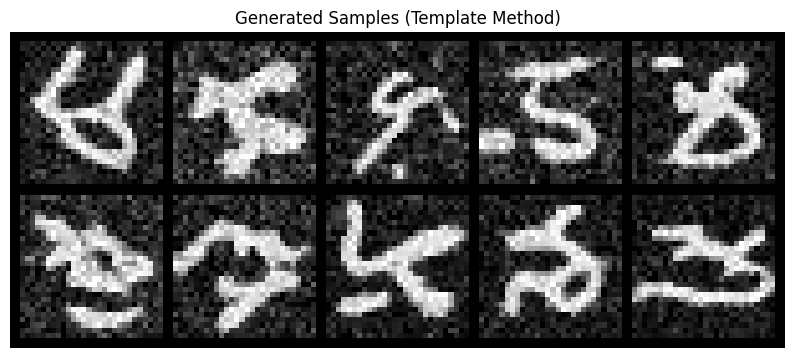


--- Epoch 9/20 ---


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Training Finished - Epoch 9 Avg Loss: 0.0591
Running validation...


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Validation Finished - Epoch 9 Avg Loss: 0.0592
Current LR: 0.001000
Val loss did not improve for 1/10 epochs.

--- Epoch 10/20 ---


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Training Finished - Epoch 10 Avg Loss: 0.0588
Running validation...


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Validation Finished - Epoch 10 Avg Loss: 0.0593
Current LR: 0.001000
Val loss did not improve for 2/10 epochs.

Generating samples end of epoch 10...


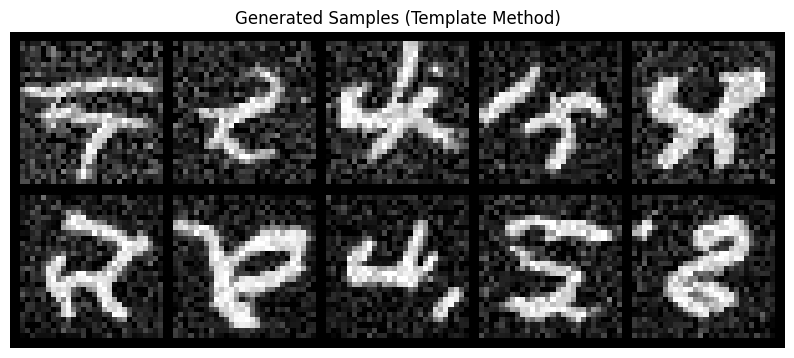

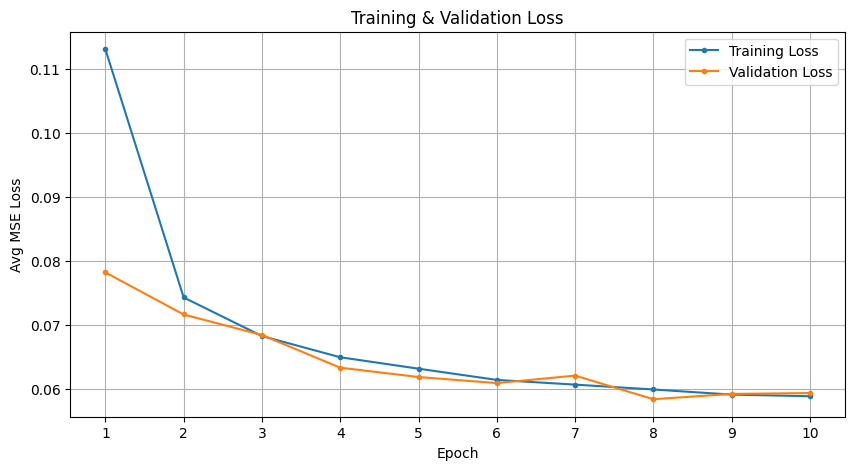


--- Epoch 11/20 ---


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Training Finished - Epoch 11 Avg Loss: 0.0582
Running validation...


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Validation Finished - Epoch 11 Avg Loss: 0.0581
Current LR: 0.001000
✓ New best model! Saving to 'best_diffusion_model_mnist_basic_deepseekfix.pth' (Val Loss: 0.0581)
(Success) Model successfully saved to best_diffusion_model_mnist_basic_deepseekfix.pth

--- Epoch 12/20 ---


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Training Finished - Epoch 12 Avg Loss: 0.0582
Running validation...


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Validation Finished - Epoch 12 Avg Loss: 0.0570
Current LR: 0.001000
✓ New best model! Saving to 'best_diffusion_model_mnist_basic_deepseekfix.pth' (Val Loss: 0.0570)
(Success) Model successfully saved to best_diffusion_model_mnist_basic_deepseekfix.pth

Generating samples end of epoch 12...


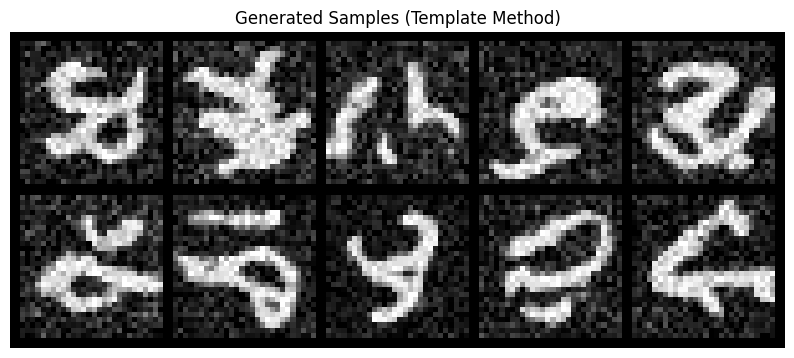


--- Epoch 13/20 ---


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Training Finished - Epoch 13 Avg Loss: 0.0576
Running validation...


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Validation Finished - Epoch 13 Avg Loss: 0.0574
Current LR: 0.001000
Val loss did not improve for 1/10 epochs.

--- Epoch 14/20 ---


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Training Finished - Epoch 14 Avg Loss: 0.0577
Running validation...


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Validation Finished - Epoch 14 Avg Loss: 0.0576
Current LR: 0.001000
Val loss did not improve for 2/10 epochs.

Generating samples end of epoch 14...


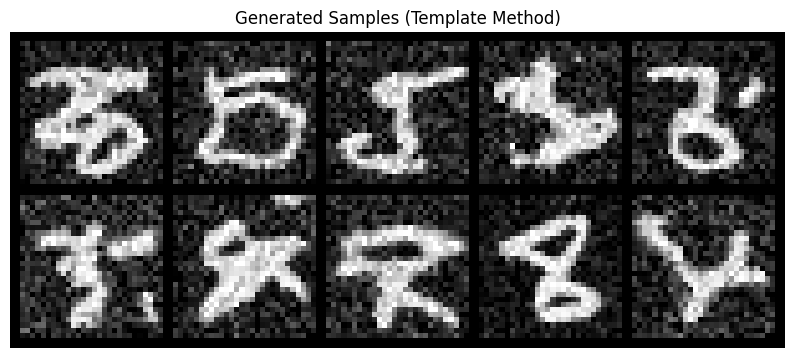


--- Epoch 15/20 ---


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Training Finished - Epoch 15 Avg Loss: 0.0574
Running validation...


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Validation Finished - Epoch 15 Avg Loss: 0.0582
Current LR: 0.001000
Val loss did not improve for 3/10 epochs.


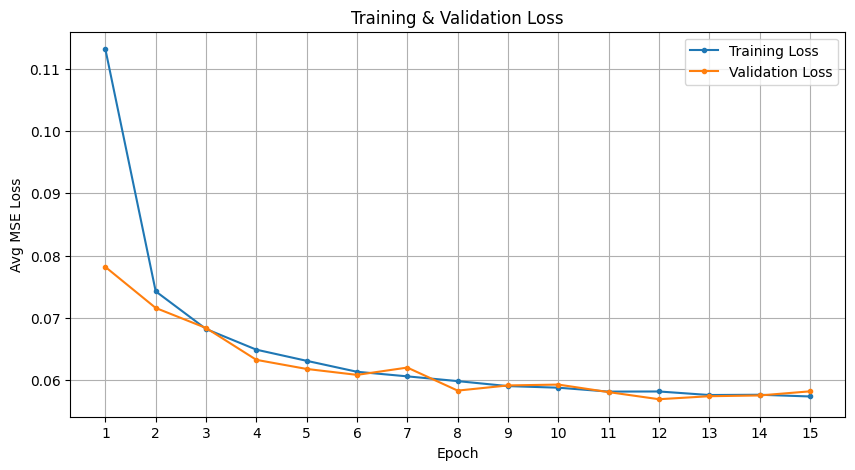


--- Epoch 16/20 ---


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Training Finished - Epoch 16 Avg Loss: 0.0572
Running validation...


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Validation Finished - Epoch 16 Avg Loss: 0.0569
Current LR: 0.001000
✓ New best model! Saving to 'best_diffusion_model_mnist_basic_deepseekfix.pth' (Val Loss: 0.0569)
(Success) Model successfully saved to best_diffusion_model_mnist_basic_deepseekfix.pth

Generating samples end of epoch 16...


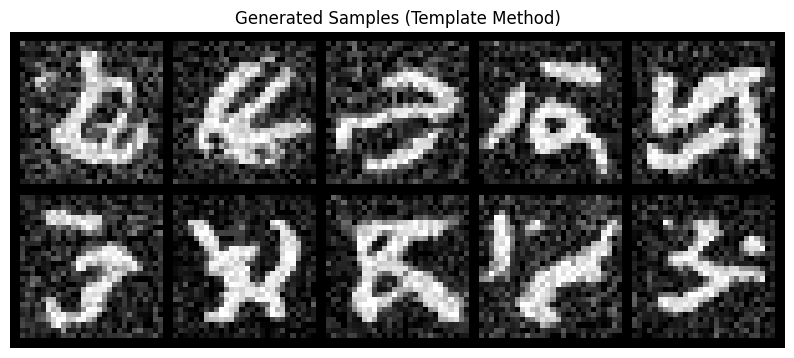


--- Epoch 17/20 ---


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Training Finished - Epoch 17 Avg Loss: 0.0569
Running validation...


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Validation Finished - Epoch 17 Avg Loss: 0.0574
Current LR: 0.001000
Val loss did not improve for 1/10 epochs.

--- Epoch 18/20 ---


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Training Finished - Epoch 18 Avg Loss: 0.0570
Running validation...


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Validation Finished - Epoch 18 Avg Loss: 0.0563
Current LR: 0.001000
✓ New best model! Saving to 'best_diffusion_model_mnist_basic_deepseekfix.pth' (Val Loss: 0.0563)
(Success) Model successfully saved to best_diffusion_model_mnist_basic_deepseekfix.pth

Generating samples end of epoch 18...


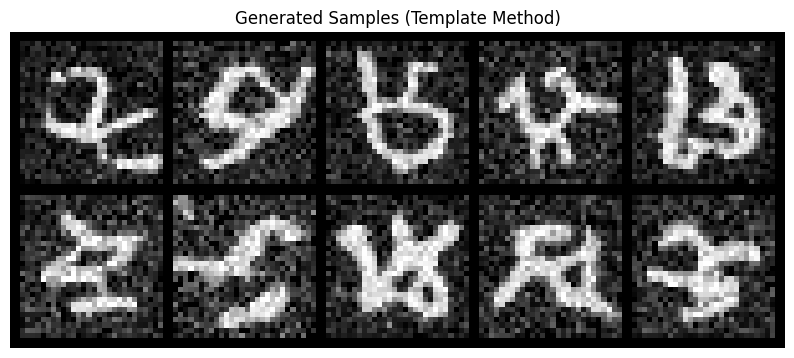


--- Epoch 19/20 ---


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Training Finished - Epoch 19 Avg Loss: 0.0569
Running validation...


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Validation Finished - Epoch 19 Avg Loss: 0.0563
Current LR: 0.001000
✓ New best model! Saving to 'best_diffusion_model_mnist_basic_deepseekfix.pth' (Val Loss: 0.0563)
(Success) Model successfully saved to best_diffusion_model_mnist_basic_deepseekfix.pth

--- Epoch 20/20 ---


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Training Finished - Epoch 20 Avg Loss: 0.0565
Running validation...


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Validation Finished - Epoch 20 Avg Loss: 0.0566
Current LR: 0.001000
Val loss did not improve for 1/10 epochs.

Generating samples end of epoch 20...


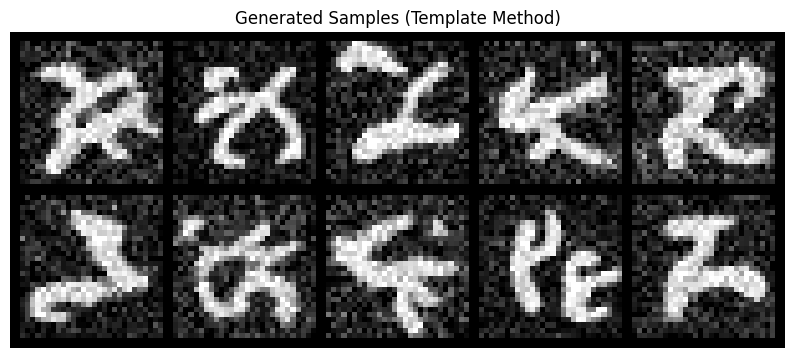

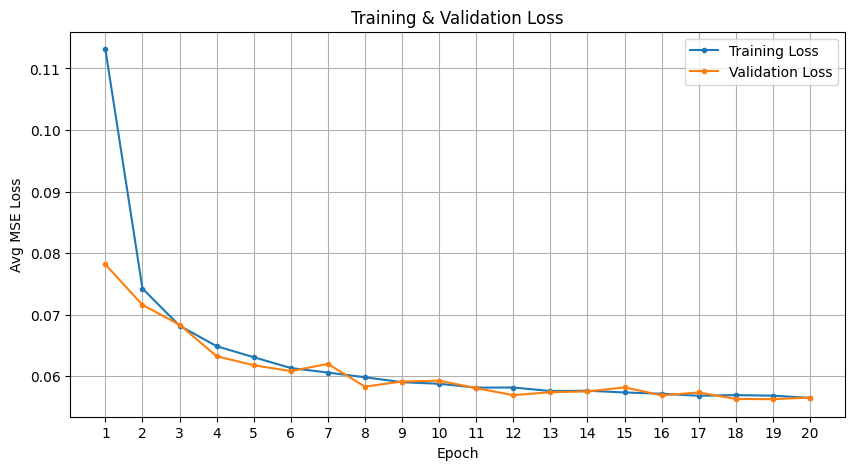


TRAINING PROCESS COMPLETE (MNIST - Basic Setup + Deepseek Fix)
Best validation loss achieved: 0.0563

Loading best model ('best_diffusion_model_mnist_basic_deepseekfix.pth') for final samples...
✓ Created UNet with 3 scale levels: (32, 64, 128)
✓ Best model loaded.


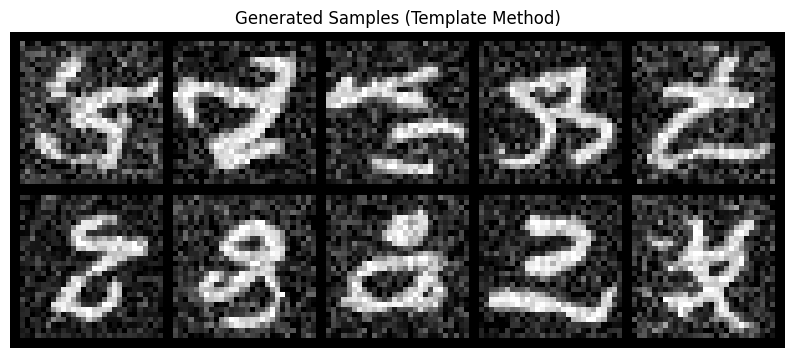


Displaying final loss curves...


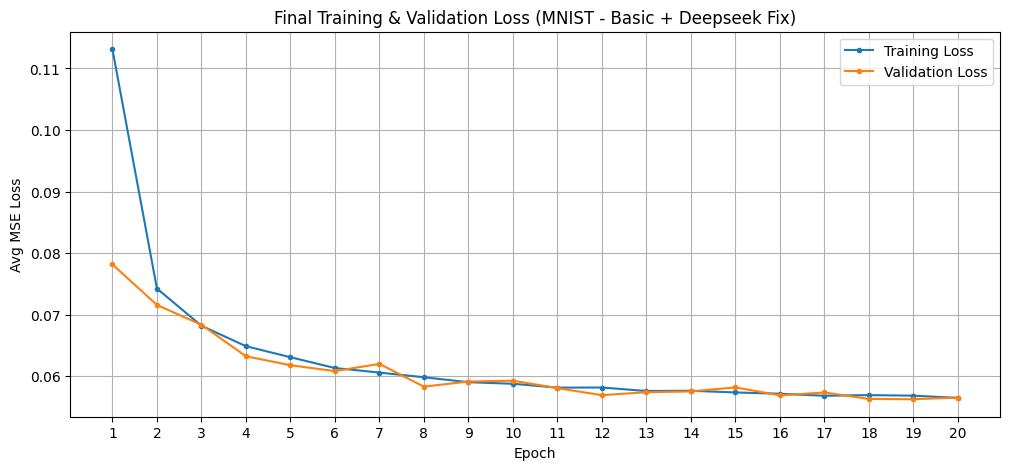


Attempting final memory cleanup...
✓ Memory cleanup attempted.


In [29]:
# ==============================================================================
# CELL 28: Step 5 Main Training Loop (Template Version)
# ==============================================================================
# Implementation of the main training loop (Template Cell 41 - BASIC VERSION)

# Progress tracking variables
best_loss = float('inf'); train_losses = []; val_losses = []; no_improve_epochs = 0

# Training loop
print("\n" + "="*50); print(f"STARTING {dataset} TRAINING (Template Defaults + Deepseek UNet Fix)")
print(f"Epochs: {EPOCHS}, Batch Size: {BATCH_SIZE}, Diffusion Steps: {n_steps}") # Check n_steps=100
print(f"Device: {device}"); print("="*50)

try:
    for epoch in range(EPOCHS): # Use EPOCHS=20 or 30 from MNIST setup
        print(f"\n--- Epoch {epoch+1}/{EPOCHS} ---")
        model.train(); epoch_train_losses = []
        pbar_train = tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc="Training", leave=False)

        for step, (images, labels) in pbar_train:
            images = images.to(device); labels = labels.to(device)
            # --- Training step (Basic) ---
            optimizer.zero_grad()
            loss = train_step(images, labels) # Call template train_step
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=gradient_clip_value)
            optimizer.step()
            # ---------------------
            current_loss_item = loss.item(); epoch_train_losses.append(current_loss_item)
            pbar_train.set_postfix(Loss=f"{current_loss_item:.4f}")

            # Generate samples mid-epoch using original non-CFG function
            if (step + 1) % generate_frequency == 0 and step > 0:
                 try:
                     print(f"\n  Generating samples mid-epoch (step {step+1})...")
                     generate_samples(model, n_samples=10) # Call template non-CFG version from Cell 26
                     model.train()
                 except Exception as e: print(f"  Error generating mid-epoch samples: {e}"); model.train()

        # End of training epoch
        avg_train_loss = sum(epoch_train_losses)/len(epoch_train_losses) if epoch_train_losses else 0
        train_losses.append(avg_train_loss); print(f"Training Finished - Epoch {epoch+1} Avg Loss: {avg_train_loss:.4f}")

        # === Validation phase ===
        model.eval(); val_epoch_losses = []; print("Running validation...")
        pbar_val = tqdm(val_dataloader, desc="Validation", leave=False)
        with torch.no_grad():
            for val_images, val_labels in pbar_val:
                val_images=val_images.to(device); val_labels=val_labels.to(device)
                # Calculate validation loss directly using basic logic
                val_c_one_hot = F.one_hot(val_labels.long(), N_CLASSES).float().to(device)
                val_c_mask = torch.ones(val_labels.shape[0], dtype=torch.bool, device=device)
                val_t = torch.randint(0, n_steps, (val_images.shape[0],), device=device, dtype=torch.long)
                val_x_t, val_noise = add_noise(val_images, val_t)
                val_predicted_noise = model(val_x_t, val_t, val_c_one_hot, val_c_mask)
                val_loss = F.mse_loss(val_predicted_noise, val_noise)
                val_epoch_losses.append(val_loss.item())
                pbar_val.set_postfix(Loss=f"{val_loss.item():.4f}")
        avg_val_loss = sum(val_epoch_losses)/len(val_epoch_losses) if val_epoch_losses else float('inf')
        val_losses.append(avg_val_loss); print(f"Validation Finished - Epoch {epoch+1} Avg Loss: {avg_val_loss:.4f}")

        # === LR Scheduling, Saving, Early Stopping (as per template) ===
        scheduler.step(avg_val_loss); current_lr = optimizer.param_groups[0]['lr']; print(f"Current LR: {current_lr:.6f}")
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss; no_improve_epochs = 0
            save_path = f'best_diffusion_model_{dataset.lower().replace("-","_")}_basic_deepseekfix.pth' # Basic save path
            print(f"✓ New best model! Saving to '{save_path}' (Val Loss: {best_loss:.4f})")
            try: safe_save_model(model, save_path, optimizer, epoch, best_loss) # Use safe_save_model
            except NameError: torch.save({'epoch': epoch,'model_state_dict': model.state_dict(),'optimizer_state_dict': optimizer.state_dict(),'best_loss': best_loss }, save_path)
        else:
            no_improve_epochs += 1; print(f"Val loss did not improve for {no_improve_epochs}/{early_stopping_patience} epochs.")
            if no_improve_epochs >= early_stopping_patience: print(f"\nEarly stopping triggered after {epoch+1} epochs."); break

        # Generate samples end of epoch using original non-CFG function
        if (epoch + 1) % epoch_generate_frequency == 0 or epoch == EPOCHS - 1:
             try:
                 print(f"\nGenerating samples end of epoch {epoch+1}...")
                 generate_samples(model, n_samples=10) # Call template non-CFG version
                 model.train()
             except Exception as e: print(f"  Error generating end-of-epoch samples: {e}"); model.train()

        # Plot loss curves periodically
        if plt and ((epoch + 1) % epoch_plot_frequency == 0 or epoch == EPOCHS - 1):
             try: # Plotting code as before...
                  plt.figure(figsize=(10, 5)); plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', marker='.'); plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', marker='.')
                  plt.xlabel('Epoch'); plt.ylabel('Avg MSE Loss'); plt.title('Training & Validation Loss'); plt.legend(); plt.grid(True); plt.xticks(range(1, len(train_losses) + 1)); plt.show()
             except Exception as e: print(f"Error plotting losses: {e}")

# === End of Training Loop ===
except KeyboardInterrupt: print("\n--- Training interrupted by user ---")
except Exception as e: print(f"\n--- An error occurred during training: {e} ---"); traceback.print_exc()

# ––– Final wrap-up ––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
print("\n" + "="*50); print(f"TRAINING PROCESS COMPLETE ({dataset} - Basic Setup + Deepseek Fix)"); print("="*50)
if val_losses: print(f"Best validation loss achieved: {best_loss:.4f}")
else: print("No validation epochs completed.")

# Generate final samples using the *best* model weights if saved
final_save_path = f'best_diffusion_model_{dataset.lower().replace("-","_")}_basic_deepseekfix.pth'
try:
    print(f"\nLoading best model ('{final_save_path}') for final samples...")
    checkpoint = torch.load(final_save_path, map_location=device)
    # Re-instantiate the model arch used for training
    final_model = UNet( T=n_steps, img_ch=IMG_CH, img_size=IMG_SIZE, down_chs=unet_down_chs,
                       t_embed_dim=unet_t_embed_dim, c_embed_dim=unet_c_embed_dim ).to(device)
    final_model.load_state_dict(checkpoint['model_state_dict']); print("✓ Best model loaded.")
    generate_samples(final_model, n_samples=10) # Generate with best model using non-CFG
except FileNotFoundError:
    print(f"Best model checkpoint not found. Generating samples from final model state.")
    generate_samples(model, n_samples=10) # Generate with final model using non-CFG
except Exception as e: print(f"Could not load/generate final samples: {e}"); traceback.print_exc()

# Display final loss curves
if plt and train_losses and val_losses:
    try: # Plotting code as before...
         print("\nDisplaying final loss curves..."); plt.figure(figsize=(12, 5)); plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', marker='.'); plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', marker='.')
         plt.xlabel('Epoch'); plt.ylabel('Avg MSE Loss'); plt.title(f'Final Training & Validation Loss ({dataset} - Basic + Deepseek Fix)'); plt.legend(); plt.grid(True); plt.xticks(range(1, len(train_losses) + 1)); plt.show()
    except Exception as e: print(f"Error plotting final losses: {e}")

# Optional: Clean up memory
print("\nAttempting final memory cleanup...")
try: # Attempt deletion
    del images, labels, val_images, val_labels, loss, val_loss, x_t, noise, predicted_noise, val_x_t, val_noise, val_predicted_noise
    del final_model, checkpoint
except NameError: pass
gc.collect(); torch.cuda.empty_cache(); print("✓ Memory cleanup attempted.")


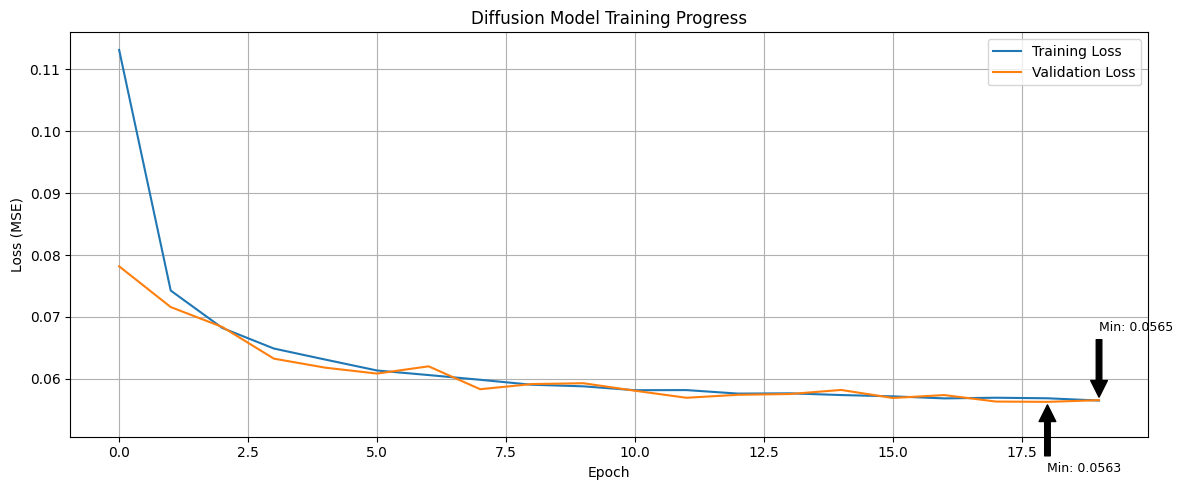


Training Statistics:
------------------------------
Starting training loss:    0.1131
Final training loss:       0.0565
Best training loss:        0.0565
Training loss improvement: 50.0%

Validation Statistics:
------------------------------
Starting validation loss: 0.0782
Final validation loss:    0.0566
Best validation loss:     0.0563


In [30]:
# Plot training progress
plt.figure(figsize=(12, 5))

# Plot training and validation losses for comparison
plt.plot(train_losses, label='Training Loss')
if len(val_losses) > 0:  # Only plot validation if it exists
    plt.plot(val_losses, label='Validation Loss')

# Improve the plot with better labels and styling
plt.title('Diffusion Model Training Progress')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)

# Add annotations for key points
if len(train_losses) > 1:
    min_train_idx = train_losses.index(min(train_losses))
    plt.annotate(f'Min: {min(train_losses):.4f}',
                 xy=(min_train_idx, min(train_losses)),
                 xytext=(min_train_idx, min(train_losses)*1.2),
                 arrowprops=dict(facecolor='black', shrink=0.05),
                 fontsize=9)

# Add validation min point if available
if len(val_losses) > 1:
    min_val_idx = val_losses.index(min(val_losses))
    plt.annotate(f'Min: {min(val_losses):.4f}',
                xy=(min_val_idx, min(val_losses)),
                xytext=(min_val_idx, min(val_losses)*0.8),
                arrowprops=dict(facecolor='black', shrink=0.05),
                fontsize=9)

# Set y-axis to start from 0 or slightly lower than min value
plt.ylim(bottom=max(0, min(min(train_losses) if train_losses else float('inf'),
                          min(val_losses) if val_losses else float('inf'))*0.9))

plt.tight_layout()
plt.show()

# Add statistics summary for students to analyze
print("\nTraining Statistics:")
print("-" * 30)
if train_losses:
    print(f"Starting training loss:    {train_losses[0]:.4f}")
    print(f"Final training loss:       {train_losses[-1]:.4f}")
    print(f"Best training loss:        {min(train_losses):.4f}")
    print(f"Training loss improvement: {((train_losses[0] - min(train_losses)) / train_losses[0] * 100):.1f}%")

if val_losses:
    print("\nValidation Statistics:")
    print("-" * 30)
    print(f"Starting validation loss: {val_losses[0]:.4f}")
    print(f"Final validation loss:    {val_losses[-1]:.4f}")
    print(f"Best validation loss:     {min(val_losses):.4f}")

# STUDENT EXERCISE:
# 1. Try modifying this plot to show a smoothed version of the losses
# 2. Create a second plot showing the ratio of validation to training loss
#    (which can indicate overfitting when the ratio increases)

## Step 6: Generating New Images

Now that our model is trained, let's generate some new images! We can:
1. Generate specific numbers
2. Generate multiple versions of each number
3. See how the generation process works step by step


Step 6: Generating New Images (Using CFG for Generation)

Loading best basic model ('best_diffusion_model_mnist_basic_deepseekfix.pth') for CFG generation...
✓ Created UNet with 3 scale levels: (32, 64, 128)
✓ Best model loaded.

Generating multiple versions of each digit using CFG...


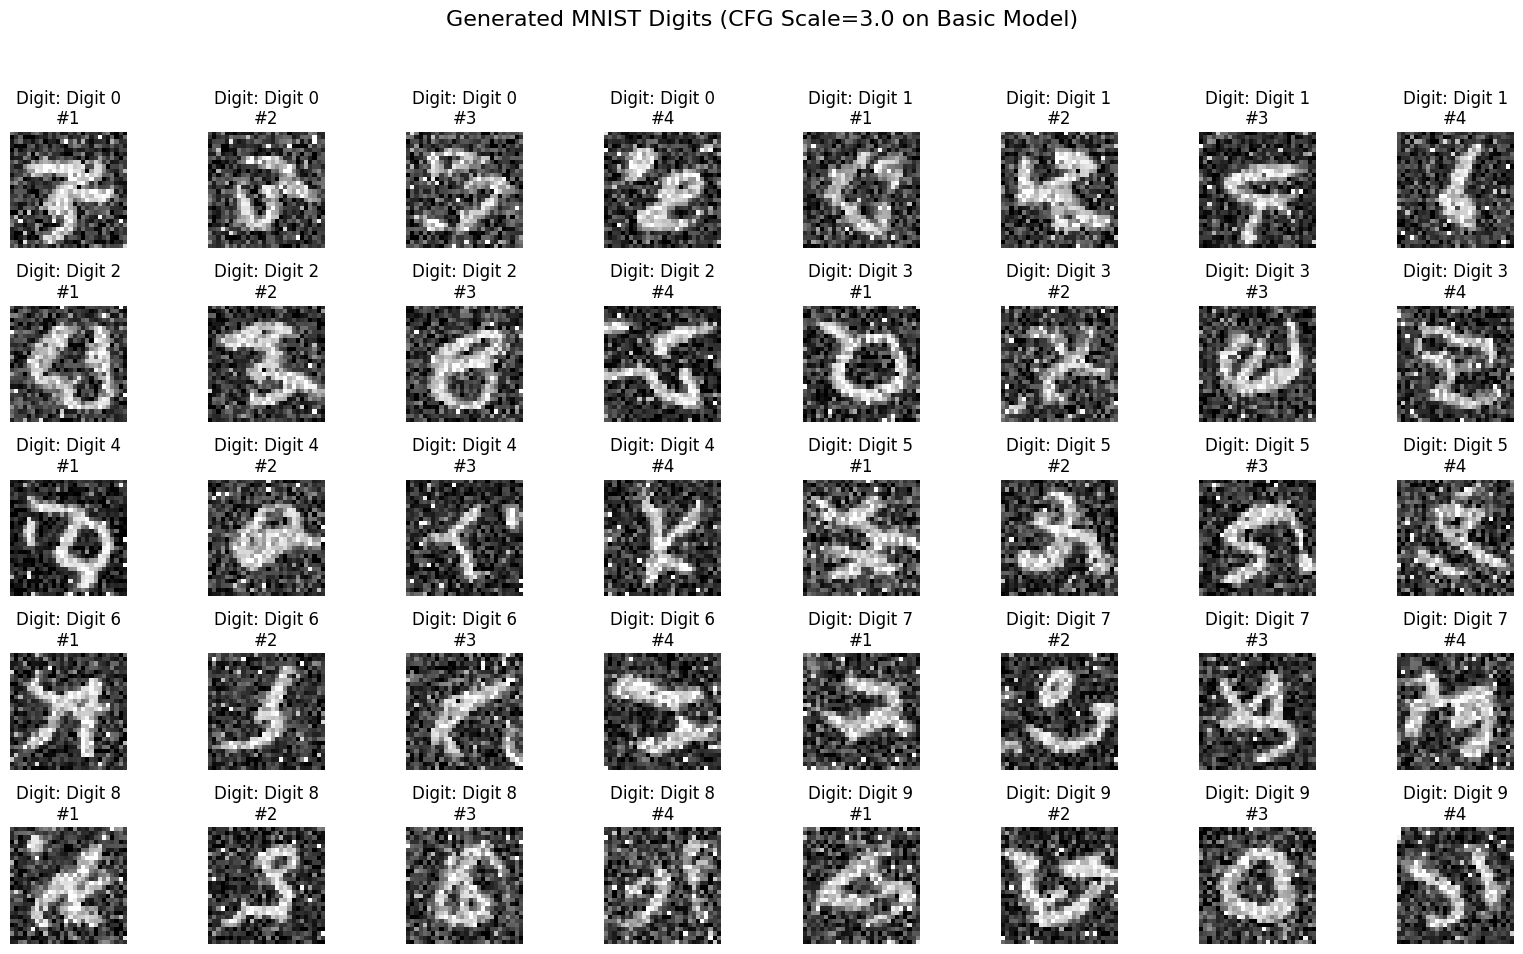


STUDENT ACTIVITY: Generating digits with different noise seeds (using CFG)
Generating variations of Digit 3 with different seeds (CFG Method)...


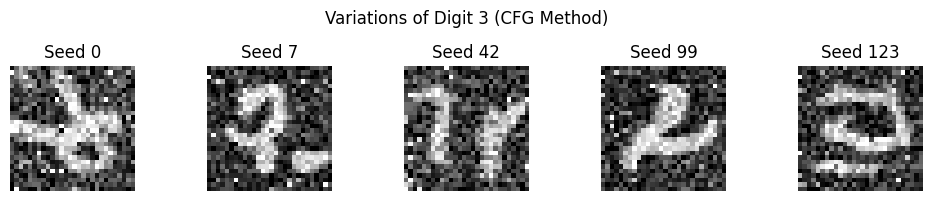

In [31]:
# ==============================================================================
# CELL 31: Step 6 Generating Images (REVISED: Redefine generate_number for CFG)
# ==============================================================================
print("\n" + "="*50); print("Step 6: Generating New Images (Using CFG for Generation)"); print("="*50)

# --- Redefine generate_number function to use CFG ---
# This version will be used for generating final images in this step and Step 8.
@torch.no_grad()
def generate_number(model, number, n_samples=4, cfg_scale=3.0): # Default CFG scale for MNIST
    """
    Generate multiple versions of a specific number using the diffusion model WITH CFG.
    Assumes model was trained (basic setup okay), uses global schedule vars (n_steps=100, linear).
    """
    model.eval() # Ensure eval mode
    # Start with random noise for all samples
    samples = torch.randn(n_samples, IMG_CH, IMG_SIZE, IMG_SIZE).to(device)

    # Prepare class conditioning
    c = torch.full((n_samples,), number, dtype=torch.long).to(device)
    c_one_hot = F.one_hot(c, N_CLASSES).float().to(device)

    # Prepare masks for conditional and unconditional CFG calls
    c_mask_cond = torch.ones(n_samples, dtype=torch.bool, device=device)   # Mask for conditional step [True, True, ...]
    c_mask_uncond = torch.zeros(n_samples, dtype=torch.bool, device=device) # Mask for unconditional step [False, False, ...]

    # print(f"Generating {n_samples} versions of digit {number} (CFG Scale: {cfg_scale})...") # Less verbose

    # --- Denoising loop using CFG ---
    # Loop from T-1 down to 0
    for t_val in range(n_steps - 1, -1, -1): # Use global n_steps=100
        # Create batch of timesteps
        t_batch = torch.full((n_samples,), t_val, device=device, dtype=torch.long)

        # Get model predictions: one conditional, one unconditional
        eps_uncond = model(samples, t_batch, c_one_hot, c_mask_uncond)
        eps_cond = model(samples, t_batch, c_one_hot, c_mask_cond)

        # Combine predictions using the CFG formula
        # eps = unconditional_pred + scale * (conditional_pred - unconditional_pred)
        eps = eps_uncond + cfg_scale * (eps_cond - eps_uncond)
        # Note: The alternative formula (1+s)cond - s*uncond might also work

        # Optional: Clamp eps if needed (recommended from previous debug)
        eps = torch.clamp(eps, -1.5, 1.5)

        # --- Denoising Step Calculation (DDPM formula) ---
        # Get schedule coefficients for this timestep t_val
        alpha_t = alpha[t_val]
        beta_t = beta[t_val]
        sqrt_alpha_t = torch.sqrt(alpha_t) # Need sqrt(alpha_t) for mean calculation
        sqrt_one_minus_alpha_bar_t = sqrt_one_minus_alpha_bar[t_val]

        # Reshape coefficients for broadcasting (scalar -> [B, 1, 1, 1])
        sqrt_alpha_t_rs = sqrt_alpha_t.view(-1, 1, 1, 1)
        beta_t_rs = beta_t.view(-1, 1, 1, 1)
        sqrt_one_minus_alpha_bar_t_rs = sqrt_one_minus_alpha_bar_t.view(-1, 1, 1, 1)

        # Add small epsilon for numerical stability in denominator
        mean_denom_term = sqrt_one_minus_alpha_bar_t_rs + 1e-9

        # Calculate the mean of the previous step's distribution x_{t-1}
        # mean = (1/sqrt(alpha_t)) * (x_t - (beta_t / sqrt(1-alpha_bar_t)) * eps_theta)
        mean = (1 / sqrt_alpha_t_rs) * (samples - (beta_t_rs / mean_denom_term) * eps)

        # Add noise if not the last step (t > 0)
        if t_val > 0:
            noise = torch.randn_like(samples)
            # Variance for DDPM sampling step is beta_t
            variance_term = torch.sqrt(beta_t_rs)
            # Update sample for next iteration
            samples = mean + variance_term * noise
        else:
            # Last step (t=0), the mean is the final generated image
            samples = mean

    # print(f"✓ Finished digit {number}.") # Less verbose
    return samples # Return images in [-1, 1] range

# --- Generate 4 versions of each number (MNIST digits) using CFG ---
# Load the BEST model saved from the BASIC training run
load_path = f'best_diffusion_model_{dataset.lower().replace("-","_")}_basic_deepseekfix.pth' # Path from basic run
try:
    print(f"\nLoading best basic model ('{load_path}') for CFG generation...")
    checkpoint = torch.load(load_path, map_location=device)
    # Re-create basic model instance architecture used during training
    unet_down_chs=(32, 64, 128); unet_t_embed_dim=8 # Basic params
    model_to_use = UNet( T=n_steps, img_ch=IMG_CH, img_size=IMG_SIZE, down_chs=unet_down_chs,
                       t_embed_dim=unet_t_embed_dim, c_embed_dim=N_CLASSES ).to(device)
    model_to_use.load_state_dict(checkpoint['model_state_dict'])
    print("✓ Best model loaded.")
except FileNotFoundError:
    print(f"⚠️ WARNING: Best model checkpoint ('{load_path}') not found. Using current 'model' state.")
    if 'model' not in locals(): raise NameError("Model not found in memory. Please rerun training or load a checkpoint.")
    model_to_use = model # Fallback to current model state from training cell
except Exception as e:
     print(f"⚠️ Error loading best model: {e}. Using current 'model' state.")
     if 'model' not in locals(): raise NameError("Model not found in memory. Please rerun training or load a checkpoint.")
     model_to_use = model

model_to_use.eval() # Ensure model is in evaluation mode

print("\nGenerating multiple versions of each digit using CFG...")
if plt:
    plt.figure(figsize=(16, 10))
    n_versions = 4
    cfg_gen_scale = 3.0 # Try a moderate CFG scale for MNIST (e.g., 3.0 or 5.0)

    for i in range(N_CLASSES): # Loop 0-9
        # Call the NEW CFG version of generate_number defined above
        samples = generate_number(model_to_use, i, n_samples=n_versions, cfg_scale=cfg_gen_scale)
        # Un-normalize images from [-1, 1] to [0, 1] for display
        samples_display = to_image(samples)

        # Display each sample
        for j in range(n_versions):
            plt.subplot(5, 8, i * n_versions + j + 1) # Simple index
            plt.imshow(samples_display[j, 0].cpu(), cmap='gray') # Display grayscale
            plt.title(f'Digit: {class_names[i]}\n#{j+1}') # Use digit names
            plt.axis('off')

    plt.suptitle(f"Generated {dataset} Digits (CFG Scale={cfg_gen_scale} on Basic Model)", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()
else:
    print("Matplotlib (plt) unavailable, skipping image grid display.")


# --- STUDENT ACTIVITY: Try generating the same digit with different noise seeds ---
print("\nSTUDENT ACTIVITY: Generating digits with different noise seeds (using CFG)")
# Helper function now calls the CFG generate_number
def generate_with_seed(number, seed_value=42, n_samples=1, cfg_scale=3.0): # Template name
    """Generates samples with a specific seed using the CFG generate_number function."""
    torch.manual_seed(seed_value)
    # Call the CFG generate_number defined above
    return generate_number(model_to_use, number, n_samples=n_samples, cfg_scale=cfg_scale) # Pass scale

digit_to_vary = 3 # Example digit
seed_list = [0, 7, 42, 99, 123]
print(f"Generating variations of Digit {digit_to_vary} with different seeds (CFG Method)...")
if plt:
    plt.figure(figsize=(len(seed_list)*2, 2))
    for i, seed in enumerate(seed_list):
        # Generate 1 sample with the specific seed
        sample = generate_with_seed(digit_to_vary, seed_value=seed, n_samples=1, cfg_scale=cfg_gen_scale)[0]
        # Un-normalize for display
        sample_display = to_image(sample)
        # Plot
        plt.subplot(1, len(seed_list), i+1); plt.imshow(sample_display[0].cpu(), cmap='gray')
        plt.title(f'Seed {seed}'); plt.axis('off')
    plt.suptitle(f'Variations of Digit {digit_to_vary} (CFG Method)')
    plt.tight_layout(); plt.show()
else:
    print("Matplotlib (plt) unavailable, skipping seed variation plot.")


Step 6: Generating New Images (Using CFG for Generation)

Loading best basic model ('best_diffusion_model_mnist_basic_deepseekfix.pth') for CFG generation...
✓ Created UNet with 3 scale levels: (32, 64, 128)
✓ Best model loaded.

Generating multiple versions of each digit using CFG...


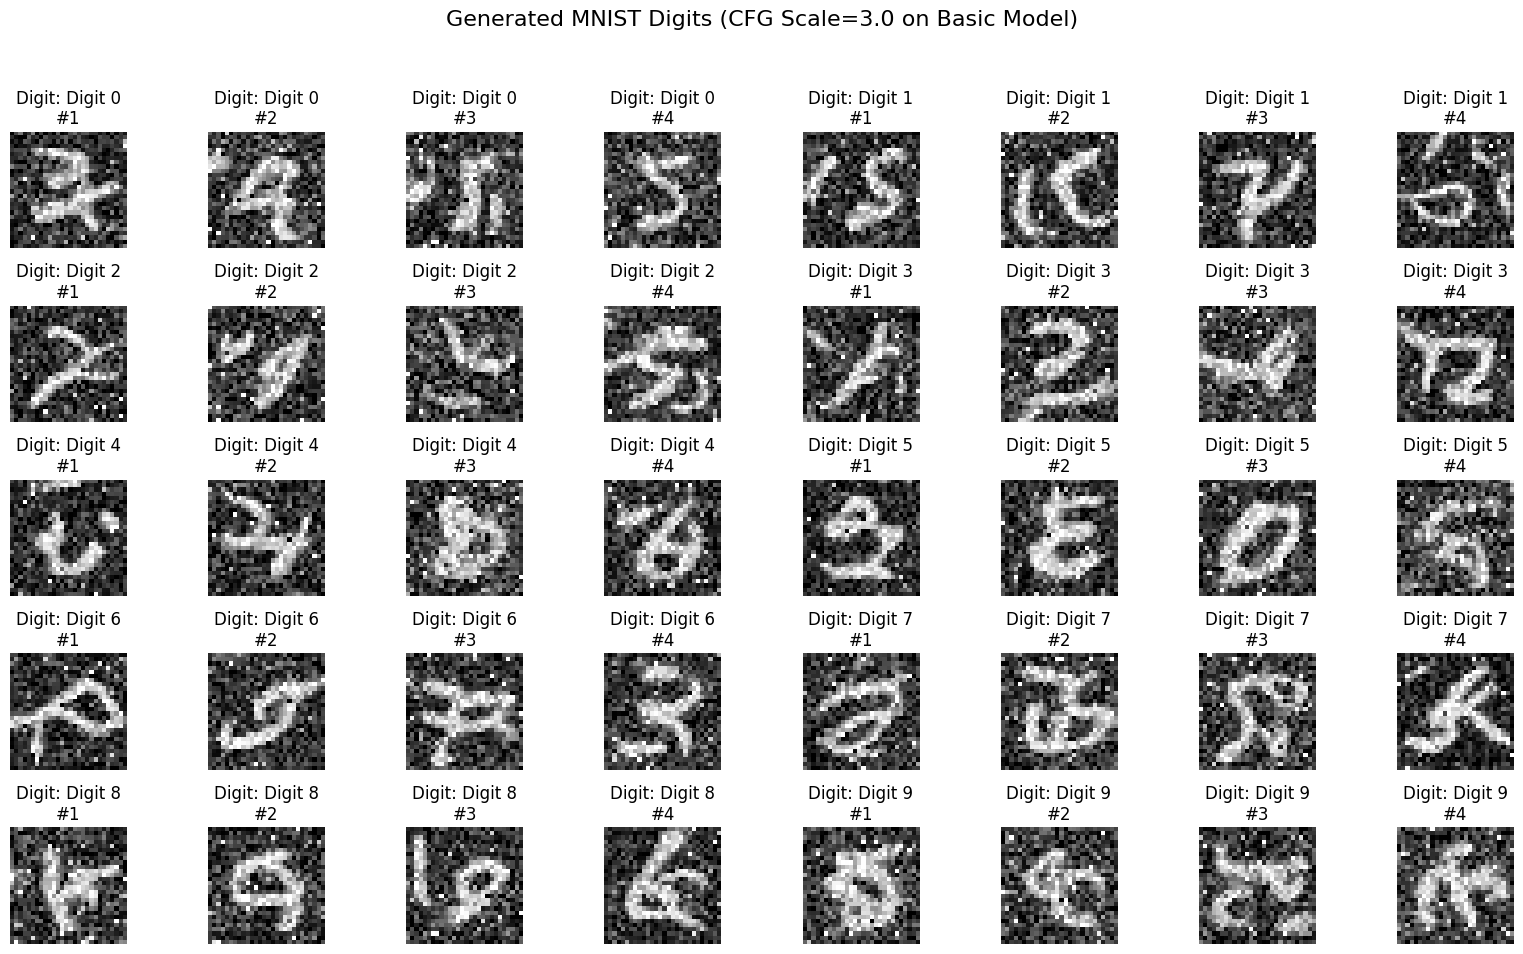


STUDENT ACTIVITY: Generating digits with different noise seeds (using CFG)
Generating variations of Digit 3 with different seeds (CFG Method)...


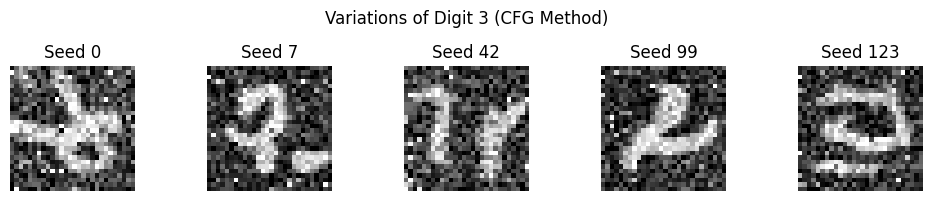

In [32]:
# ==============================================================================
# CELL 31: Step 6 Generating Images (REVISED: Redefine generate_number for CFG)
# ==============================================================================
print("\n" + "="*50); print("Step 6: Generating New Images (Using CFG for Generation)"); print("="*50)

# --- Redefine generate_number function to use CFG ---
# This version will be used for generating final images in this step and Step 8.
@torch.no_grad()
def generate_number(model, number, n_samples=4, cfg_scale=3.0): # Default CFG scale for MNIST
    """
    Generate multiple versions of a specific number using the diffusion model WITH CFG.
    Assumes model was trained (basic setup okay), uses global schedule vars (n_steps=100, linear).
    """
    model.eval() # Ensure eval mode
    # Start with random noise for all samples
    samples = torch.randn(n_samples, IMG_CH, IMG_SIZE, IMG_SIZE).to(device)

    # Prepare class conditioning
    c = torch.full((n_samples,), number, dtype=torch.long).to(device)
    c_one_hot = F.one_hot(c, N_CLASSES).float().to(device)

    # Prepare masks for conditional and unconditional CFG calls
    c_mask_cond = torch.ones(n_samples, dtype=torch.bool, device=device)   # Mask for conditional step [True, True, ...]
    c_mask_uncond = torch.zeros(n_samples, dtype=torch.bool, device=device) # Mask for unconditional step [False, False, ...]

    # print(f"Generating {n_samples} versions of digit {number} (CFG Scale: {cfg_scale})...") # Less verbose

    # --- Denoising loop using CFG ---
    # Loop from T-1 down to 0
    for t_val in range(n_steps - 1, -1, -1): # Use global n_steps=100
        # Create batch of timesteps
        t_batch = torch.full((n_samples,), t_val, device=device, dtype=torch.long)

        # Get model predictions: one conditional, one unconditional
        eps_uncond = model(samples, t_batch, c_one_hot, c_mask_uncond)
        eps_cond = model(samples, t_batch, c_one_hot, c_mask_cond)

        # Combine predictions using the CFG formula
        # eps = unconditional_pred + scale * (conditional_pred - unconditional_pred)
        eps = eps_uncond + cfg_scale * (eps_cond - eps_uncond)
        # Note: The alternative formula (1+s)cond - s*uncond might also work

        # Optional: Clamp eps if needed (recommended from previous debug)
        eps = torch.clamp(eps, -1.5, 1.5)

        # --- Denoising Step Calculation (DDPM formula) ---
        # Get schedule coefficients for this timestep t_val
        alpha_t = alpha[t_val]
        beta_t = beta[t_val]
        sqrt_alpha_t = torch.sqrt(alpha_t) # Need sqrt(alpha_t) for mean calculation
        sqrt_one_minus_alpha_bar_t = sqrt_one_minus_alpha_bar[t_val]

        # Reshape coefficients for broadcasting (scalar -> [B, 1, 1, 1])
        sqrt_alpha_t_rs = sqrt_alpha_t.view(-1, 1, 1, 1)
        beta_t_rs = beta_t.view(-1, 1, 1, 1)
        sqrt_one_minus_alpha_bar_t_rs = sqrt_one_minus_alpha_bar_t.view(-1, 1, 1, 1)

        # Add small epsilon for numerical stability in denominator
        mean_denom_term = sqrt_one_minus_alpha_bar_t_rs + 1e-9

        # Calculate the mean of the previous step's distribution x_{t-1}
        # mean = (1/sqrt(alpha_t)) * (x_t - (beta_t / sqrt(1-alpha_bar_t)) * eps_theta)
        mean = (1 / sqrt_alpha_t_rs) * (samples - (beta_t_rs / mean_denom_term) * eps)

        # Add noise if not the last step (t > 0)
        if t_val > 0:
            noise = torch.randn_like(samples)
            # Variance for DDPM sampling step is beta_t
            variance_term = torch.sqrt(beta_t_rs)
            # Update sample for next iteration
            samples = mean + variance_term * noise
        else:
            # Last step (t=0), the mean is the final generated image
            samples = mean

    # print(f"✓ Finished digit {number}.") # Less verbose
    return samples # Return images in [-1, 1] range

# --- Generate 4 versions of each number (MNIST digits) using CFG ---
# Load the BEST model saved from the BASIC training run
load_path = f'best_diffusion_model_{dataset.lower().replace("-","_")}_basic_deepseekfix.pth' # Path from basic run
try:
    print(f"\nLoading best basic model ('{load_path}') for CFG generation...")
    checkpoint = torch.load(load_path, map_location=device)
    # Re-create basic model instance architecture used during training
    unet_down_chs=(32, 64, 128); unet_t_embed_dim=8 # Basic params
    model_to_use = UNet( T=n_steps, img_ch=IMG_CH, img_size=IMG_SIZE, down_chs=unet_down_chs,
                       t_embed_dim=unet_t_embed_dim, c_embed_dim=N_CLASSES ).to(device)
    model_to_use.load_state_dict(checkpoint['model_state_dict'])
    print("✓ Best model loaded.")
except FileNotFoundError:
    print(f"⚠️ WARNING: Best model checkpoint ('{load_path}') not found. Using current 'model' state.")
    if 'model' not in locals(): raise NameError("Model not found in memory. Please rerun training or load a checkpoint.")
    model_to_use = model # Fallback to current model state from training cell
except Exception as e:
     print(f"⚠️ Error loading best model: {e}. Using current 'model' state.")
     if 'model' not in locals(): raise NameError("Model not found in memory. Please rerun training or load a checkpoint.")
     model_to_use = model

model_to_use.eval() # Ensure model is in evaluation mode

print("\nGenerating multiple versions of each digit using CFG...")
if plt:
    plt.figure(figsize=(16, 10))
    n_versions = 4
    cfg_gen_scale = 3.0 # Try a moderate CFG scale for MNIST (e.g., 3.0 or 5.0)

    for i in range(N_CLASSES): # Loop 0-9
        # Call the NEW CFG version of generate_number defined above
        samples = generate_number(model_to_use, i, n_samples=n_versions, cfg_scale=cfg_gen_scale)
        # Un-normalize images from [-1, 1] to [0, 1] for display
        samples_display = to_image(samples)

        # Display each sample
        for j in range(n_versions):
            plt.subplot(5, 8, i * n_versions + j + 1) # Simple index
            plt.imshow(samples_display[j, 0].cpu(), cmap='gray') # Display grayscale
            plt.title(f'Digit: {class_names[i]}\n#{j+1}') # Use digit names
            plt.axis('off')

    plt.suptitle(f"Generated {dataset} Digits (CFG Scale={cfg_gen_scale} on Basic Model)", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()
else:
    print("Matplotlib (plt) unavailable, skipping image grid display.")


# --- STUDENT ACTIVITY: Try generating the same digit with different noise seeds ---
print("\nSTUDENT ACTIVITY: Generating digits with different noise seeds (using CFG)")
# Helper function now calls the CFG generate_number
def generate_with_seed(number, seed_value=42, n_samples=1, cfg_scale=3.0): # Template name
    """Generates samples with a specific seed using the CFG generate_number function."""
    torch.manual_seed(seed_value)
    # Call the CFG generate_number defined above
    return generate_number(model_to_use, number, n_samples=n_samples, cfg_scale=cfg_scale) # Pass scale

digit_to_vary = 3 # Example digit
seed_list = [0, 7, 42, 99, 123]
print(f"Generating variations of Digit {digit_to_vary} with different seeds (CFG Method)...")
if plt:
    plt.figure(figsize=(len(seed_list)*2, 2))
    for i, seed in enumerate(seed_list):
        # Generate 1 sample with the specific seed
        sample = generate_with_seed(digit_to_vary, seed_value=seed, n_samples=1, cfg_scale=cfg_gen_scale)[0]
        # Un-normalize for display
        sample_display = to_image(sample)
        # Plot
        plt.subplot(1, len(seed_list), i+1); plt.imshow(sample_display[0].cpu(), cmap='gray')
        plt.title(f'Seed {seed}'); plt.axis('off')
    plt.suptitle(f'Variations of Digit {digit_to_vary} (CFG Method)')
    plt.tight_layout(); plt.show()
else:
    print("Matplotlib (plt) unavailable, skipping seed variation plot.")

## Step 7: Watching the Generation Process

Let's see how our model turns random noise into clear images, step by step. This helps us understand how the diffusion process works!


Step 7: Watching the Generation Process (Using CFG)

Visualizing step-by-step generation using CFG...

Visualizing generation steps for Digit: 0 (CFG Scale: 3.0)


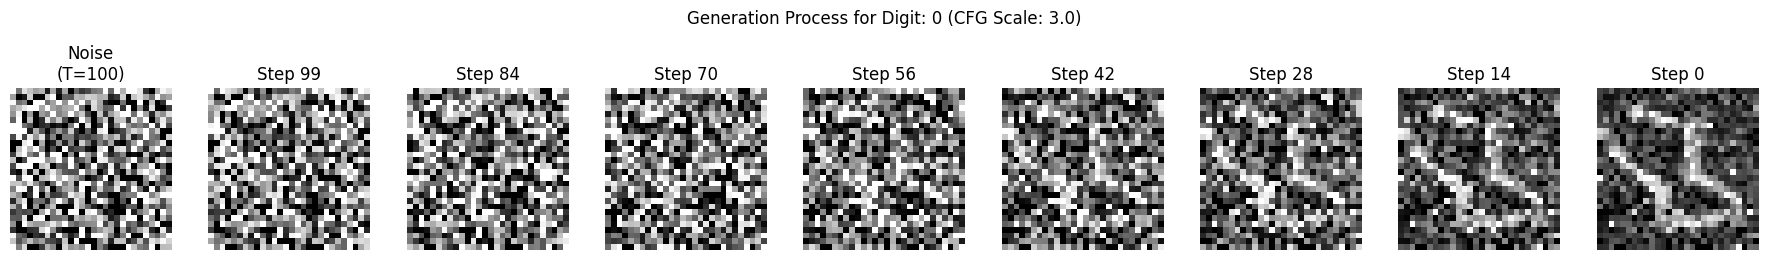


Visualizing generation steps for Digit: 3 (CFG Scale: 3.0)


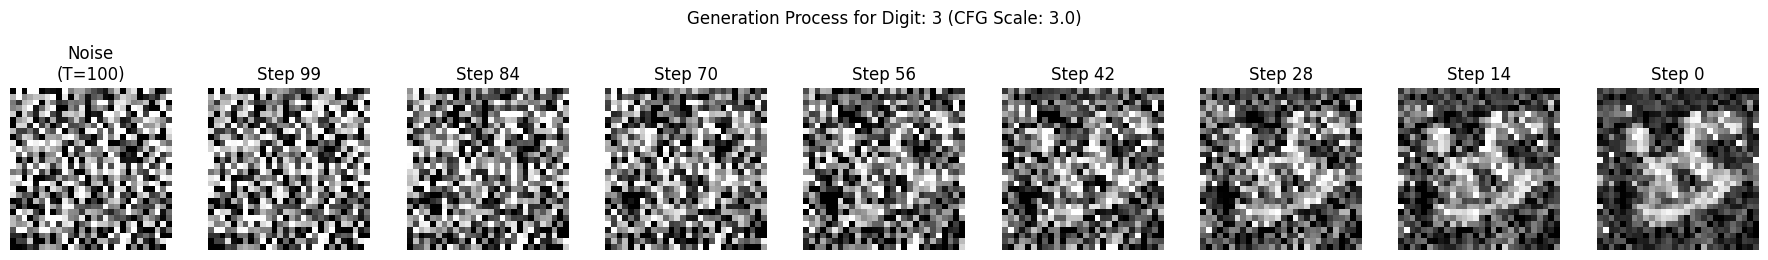


Visualizing generation steps for Digit: 7 (CFG Scale: 3.0)


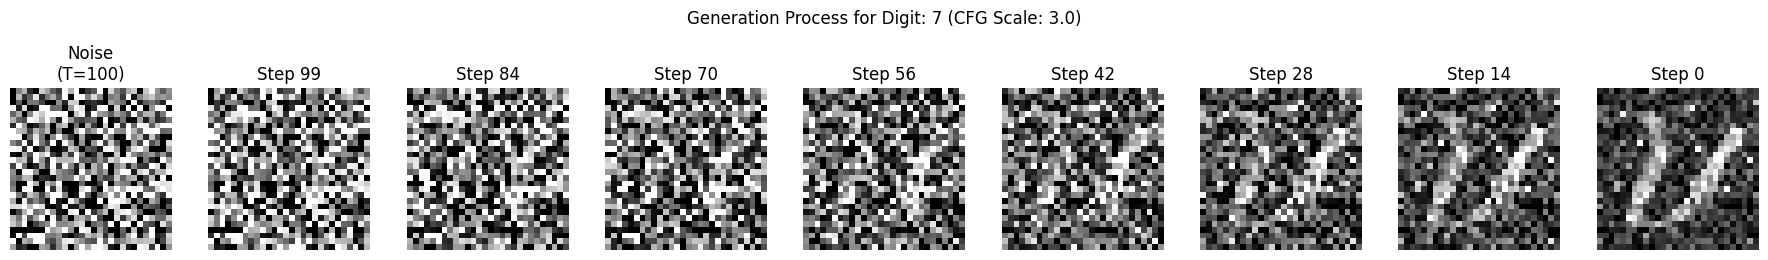

In [33]:
# ==============================================================================
# CELL 33: Step 7 Visualizing Generation (REVISED: CFG Generation)
# ==============================================================================
print("\n" + "="*50); print("Step 7: Watching the Generation Process (Using CFG)"); print("="*50)

# --- Redefine visualize_generation_steps function to use CFG ---
@torch.no_grad()
def visualize_generation_steps(model, number, n_preview_steps=10, cfg_scale=3.0): # Default CFG scale
    """Show how an image evolves from noise to a clear number using CFG."""
    model.eval()
    print(f"\nVisualizing generation steps for Digit: {number} (CFG Scale: {cfg_scale})")
    x = torch.randn(1, IMG_CH, IMG_SIZE, IMG_SIZE).to(device)
    c = torch.tensor([number], dtype=torch.long).to(device)
    c_one_hot = F.one_hot(c, N_CLASSES).float().to(device)
    c_mask_cond = torch.ones(1, dtype=torch.bool, device=device)
    c_mask_uncond = torch.zeros(1, dtype=torch.bool, device=device)
    steps_to_show_indices = torch.linspace(n_steps - 1, 0, n_preview_steps).long().unique()
    steps_to_show_indices = torch.sort(steps_to_show_indices, descending=True).values
    images = [to_image(x[0].cpu())] # Store initial noise

    # Denoising loop using CFG
    for t_val in range(n_steps - 1, -1, -1): # Use global n_steps=100
        t_batch = torch.full((1,), t_val, device=device, dtype=torch.long)
        eps_uncond = model(x, t_batch, c_one_hot, c_mask_uncond)
        eps_cond = model(x, t_batch, c_one_hot, c_mask_cond)
        eps = eps_uncond + cfg_scale * (eps_cond - eps_uncond) # CFG combination
        eps = torch.clamp(eps, -1.5, 1.5) # Apply clamping
        # Denoising Step
        alpha_t=alpha[t_val]; beta_t=beta[t_val]; sqrt_one_minus_alpha_bar_t=sqrt_one_minus_alpha_bar[t_val]
        sqrt_alpha_t_rs=torch.sqrt(alpha_t).view(-1,1,1,1); beta_t_rs=beta_t.view(-1,1,1,1); sqrt_one_minus_alpha_bar_t_rs=sqrt_one_minus_alpha_bar_t.view(-1,1,1,1)
        mean_denom_term = sqrt_one_minus_alpha_bar_t_rs + 1e-9
        mean = (1/sqrt_alpha_t_rs) * (x-(beta_t_rs/mean_denom_term)*eps)
        if t_val > 0: noise=torch.randn_like(x); variance=torch.sqrt(beta_t_rs); x=mean+variance*noise
        else: x=mean
        if t_val in steps_to_show_indices: images.append(to_image(x[0].cpu())) # Un-normalize

    # Show the progression
    if plt:
        plt.figure(figsize=(2 * len(images), 2.5))
        for i, img in enumerate(images):
            plt.subplot(1, len(images), i + 1); plt.imshow(img[0], cmap='gray'); plt.axis('off')
            step_title = f'Noise\n(T={n_steps})' if i == 0 else f'Step {steps_to_show_indices[i-1].item()}'
            plt.title(step_title)
        plt.suptitle(f'Generation Process for Digit: {number} (CFG Scale: {cfg_scale})', y=1.02)
        plt.tight_layout(rect=[0, 0, 1, 0.95]); plt.show()
    else: print("Matplotlib unavailable.")

# --- Show generation process for a few digits using CFG ---
# Use the same loaded model state as Step 6
if 'model_to_use' not in locals(): model_to_use = model
model_to_use.eval()
digit_indices_to_visualize = [0, 3, 7]
cfg_vis_scale = 3.0 # Choose a scale that looked reasonable from Step 6 comparison

print("\nVisualizing step-by-step generation using CFG...")
for number in digit_indices_to_visualize:
    # Call the NEW CFG visualization function defined above
    visualize_generation_steps(model_to_use, number, n_preview_steps=8, cfg_scale=cfg_vis_scale)


## Step 8: Adding CLIP Evaluation

[CLIP](https://openai.com/research/clip) is a powerful AI model that can understand both images and text. We'll use it to:
1. Evaluate how realistic our generated images are
2. Score how well they match their intended numbers
3. Help guide the generation process towards better quality

In [36]:
## Step 8: Adding CLIP Evaluation

# CLIP (Contrastive Language-Image Pre-training) is a powerful model by OpenAI that connects text and images.
# We'll use it to evaluate how recognizable our generated digits are by measuring how strongly
# the CLIP model associates our generated images with text descriptions like "an image of the digit 7".

# First, we need to install CLIP and its dependencies
print("Setting up CLIP (Contrastive Language-Image Pre-training) model...")

# Track installation status
clip_available = False

try:
    # Install dependencies first - these help CLIP process text and images
    print("Installing CLIP dependencies...")
    !pip install -q ftfy regex tqdm

    # Install CLIP from GitHub
    print("Installing CLIP from GitHub repository...")
    !pip install -q git+https://github.com/openai/CLIP.git

    # Import and verify CLIP is working
    print("Importing CLIP...")
    import clip

    # Test that CLIP is functioning
    models = clip.available_models()
    print(f"✓ CLIP installation successful! Available models: {models}")
    clip_available = True

except ImportError:
    print("❌ Error importing CLIP. Installation might have failed.")
    print("Try manually running: !pip install git+https://github.com/openai/CLIP.git")
    print("If you're in a Colab notebook, try restarting the runtime after installation.")

except Exception as e:
    print(f"❌ Error during CLIP setup: {e}")
    print("Some CLIP functionality may not work correctly.")

# Provide guidance based on installation result
if clip_available:
    print("\nCLIP is now available for evaluating your generated images!")
else:
    print("\nWARNING: CLIP installation failed. We'll skip the CLIP evaluation parts.")

# Import necessary libraries
import functools
import torch.nn.functional as F


Setting up CLIP (Contrastive Language-Image Pre-training) model...
Installing CLIP dependencies...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.4 MB/s eta 0:00:00
Installing CLIP from GitHub repository...
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 126.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 97.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━

 Below we are createing  a helper function to manage GPU memory when using CLIP. CLIP can be memory-intensive, so this will help prevent out-of-memory errors:

In [37]:
# Memory management decorator to prevent GPU OOM errors
def manage_gpu_memory(func):
    """
    Decorator that ensures proper GPU memory management.

    This wraps functions that might use large amounts of GPU memory,
    making sure memory is properly freed after function execution.
    """
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        if torch.cuda.is_available():
            # Clear cache before running function
            torch.cuda.empty_cache()
            try:
                return func(*args, **kwargs)
            finally:
                # Clear cache after running function regardless of success/failure
                torch.cuda.empty_cache()
        return func(*args, **kwargs)
    return wrapper


--- Step 8: Evaluating Generated MNIST Samples with CLIP ---

Loading CLIP model (ViT-B/32)...
✓ Successfully loaded CLIP model.

Generating (CFG Scale=3.0) and evaluating digit 0...


<ipython-input-39-75689fe3e09e>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


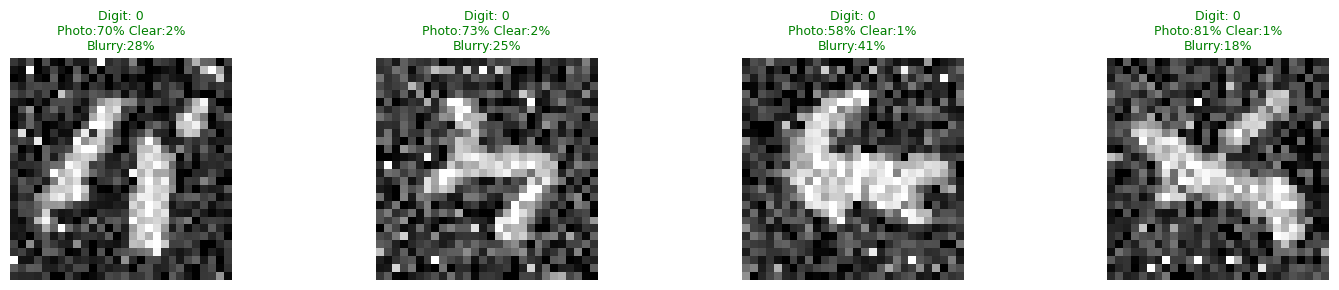


Generating (CFG Scale=3.0) and evaluating digit 1...


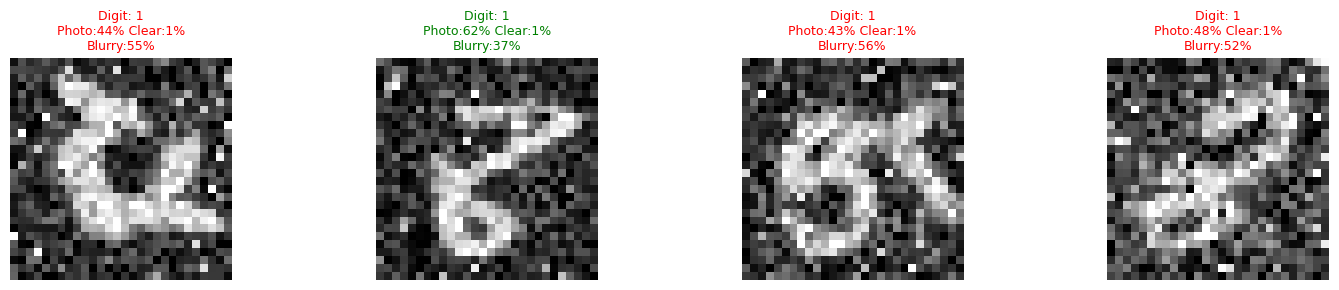


Generating (CFG Scale=3.0) and evaluating digit 2...


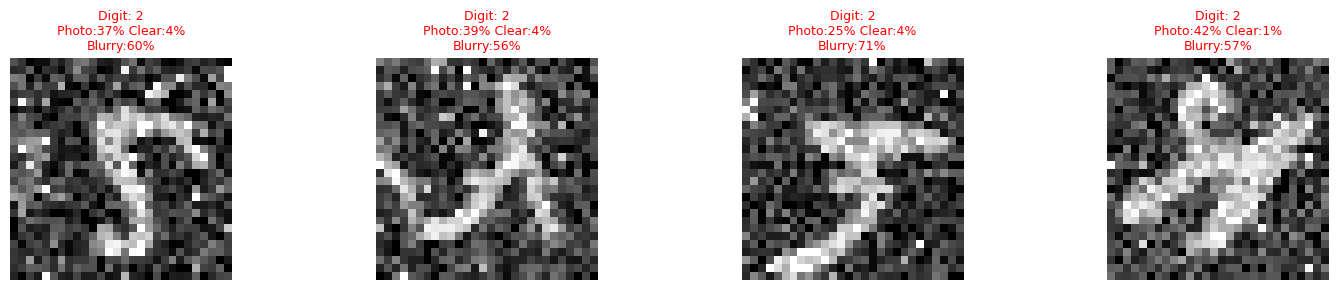


Generating (CFG Scale=3.0) and evaluating digit 3...


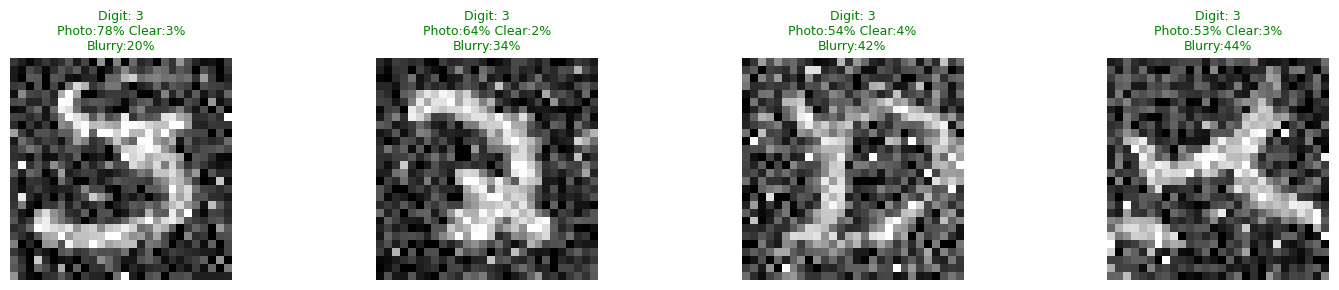


Generating (CFG Scale=3.0) and evaluating digit 4...


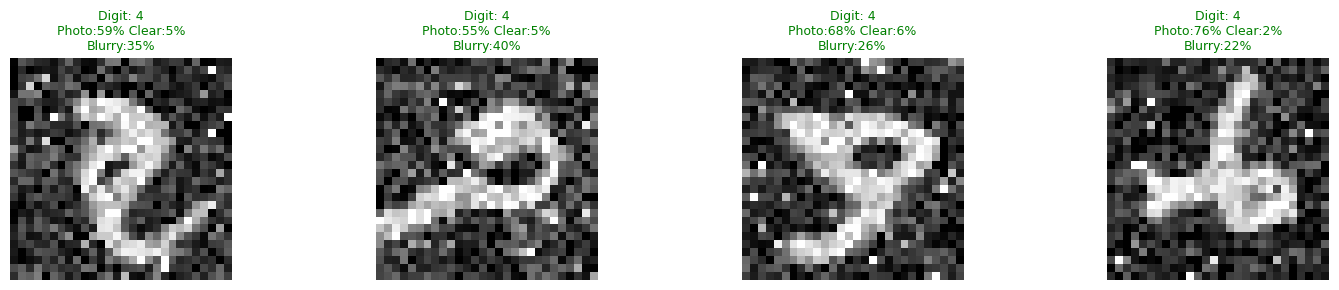


Generating (CFG Scale=3.0) and evaluating digit 5...


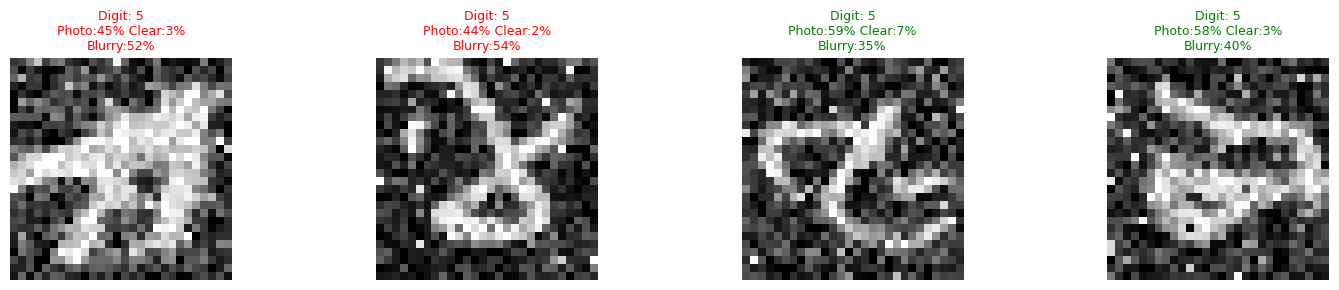


Generating (CFG Scale=3.0) and evaluating digit 6...


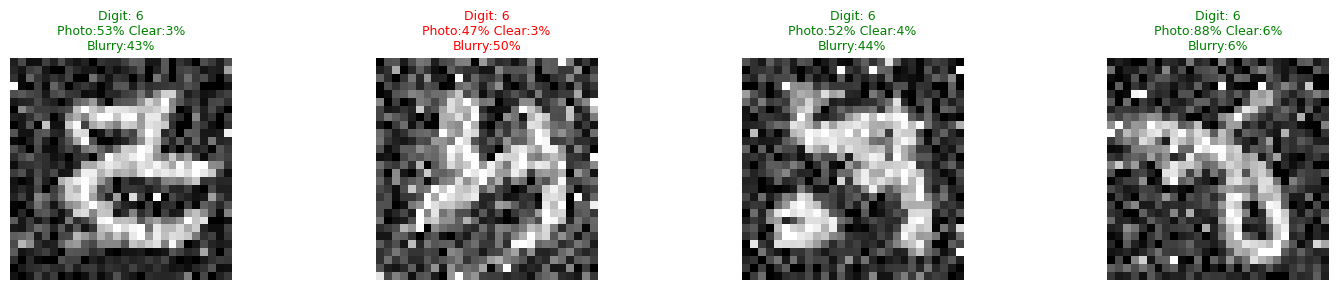


Generating (CFG Scale=3.0) and evaluating digit 7...


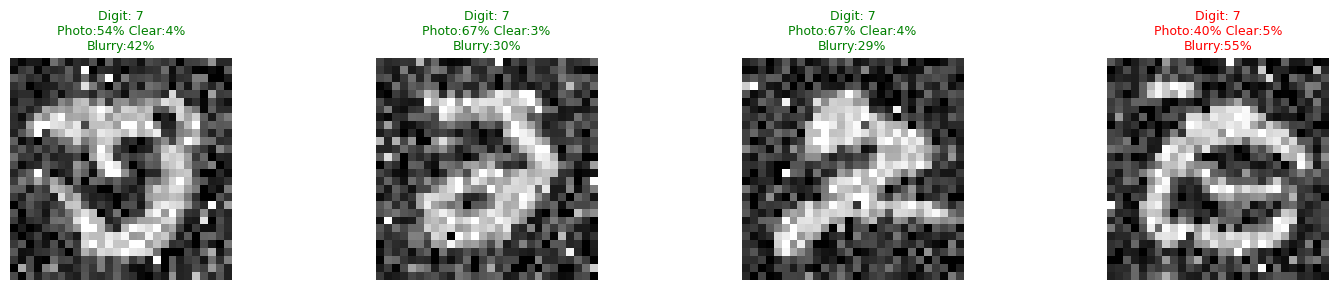


Generating (CFG Scale=3.0) and evaluating digit 8...


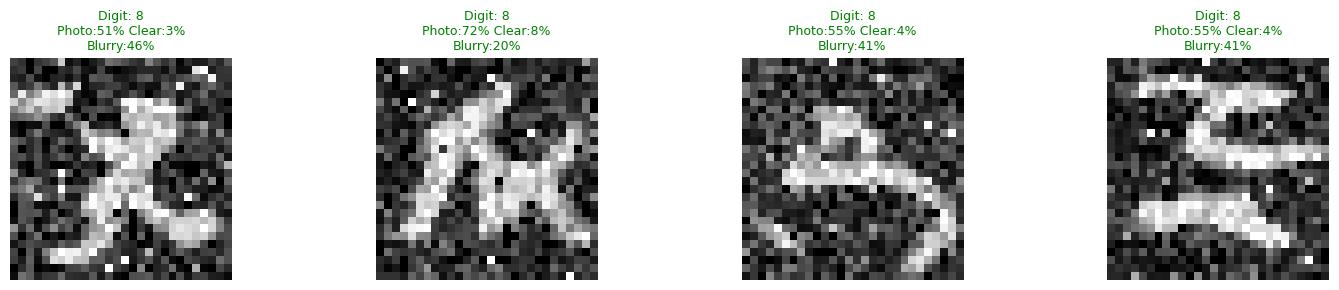


Generating (CFG Scale=3.0) and evaluating digit 9...


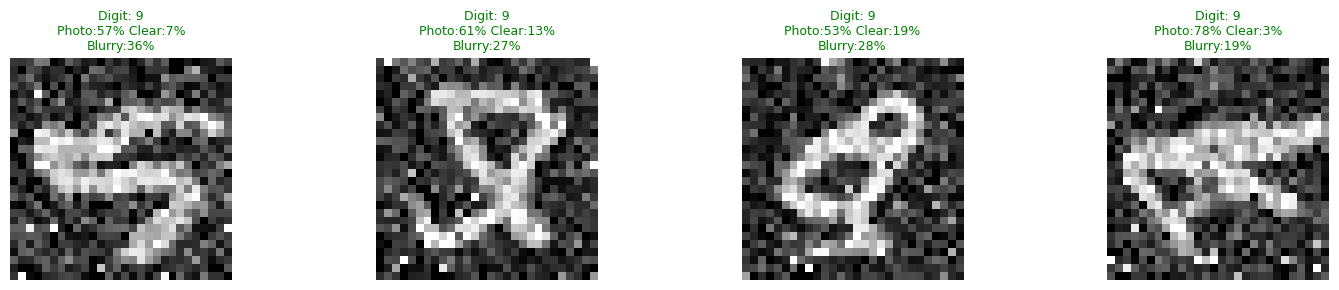


--- Average CLIP Scores per Digit (CFG Generated Samples) ---
Digit | Photo% | Clear% | Blurry%
------|--------|--------|---------
  0   |   70.6 |    1.6 |    27.9
  1   |   49.2 |    0.8 |    50.0
  2   |   35.8 |    3.3 |    60.9
  3   |   62.1 |    2.9 |    35.0
  4   |   64.8 |    4.6 |    30.7
  5   |   51.3 |    3.6 |    45.1
  6   |   60.1 |    4.2 |    35.7
  7   |   57.1 |    3.9 |    39.0
  8   |   58.3 |    4.7 |    37.0
  9   |   61.9 |   10.6 |    27.5
-------------------------------------

STUDENT ACTIVITY:
Try the code below to evaluate a larger sample of a specific digit

# Example: Generate and evaluate 10 examples of the digit 6
# digit = 6
# samples = generate_number(model, digit, n_samples=10) 
# similarities = evaluate_with_clip(samples, digit)
# 
# # Calculate what percentage of samples CLIP considers "good quality"
# # (either "good handwritten" or "clear" score exceeds "blurry" score)
# good_or_clear = (similarities[:,0] + similarities[:,1] > similarities[:,2]

In [39]:
# ==============================================================================
# CELL 38: Step 8 CLIP Loading & Evaluation (CORRECTED ERROR HANDLING)
# ==============================================================================
print(f"\n--- Step 8: Evaluating Generated {dataset} Samples with CLIP ---")

# Define clip_model and clip_preprocess as None initially
clip_model = None
clip_preprocess = None

# Load CLIP model only if installation succeeded
if clip_available:
    try:
        print("\nLoading CLIP model (ViT-B/32)...")
        clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)
        print(f"✓ Successfully loaded CLIP model.")
    except Exception as e:
        print(f"❌ Failed to load CLIP model: {e}")
        clip_available = False # Mark as unavailable if loading fails
else:
    print("\nCLIP not available, skipping model loading.")

# Use the memory management decorator (assuming it was defined in Cell 37)
@manage_gpu_memory
def evaluate_with_clip(images, target_number, max_batch_size=64):
    """
    Use CLIP to evaluate generated images. Returns default tensor on error.
    """
    # Check if CLIP loaded successfully at the start
    if not clip_available or clip_model is None:
        # print("⚠️ CLIP not available/loaded. Returning default scores.") # Less verbose
        # Return a tensor of default scores (e.g., uniform probability)
        return torch.ones(len(images), 3, device=device) / 3

    try:
        # Process in chunks if needed
        if len(images) > max_batch_size:
            all_similarities = []
            num_batches = (len(images) + max_batch_size - 1) // max_batch_size
            print(f"Processing {len(images)} images with CLIP in {num_batches} batches...")
            for i in range(0, len(images), max_batch_size):
                batch = images[i:i+max_batch_size]
                # Use autocast for potential memory/speed benefits
                with torch.no_grad(), torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
                    # Call internal batch processor
                    batch_similarities = _process_clip_batch(batch, target_number)
                    # Check if _process_clip_batch returned None due to internal error
                    if batch_similarities is None:
                         print(f"  Skipping batch {i//max_batch_size + 1} due to processing error.")
                         # Append default scores for this batch
                         all_similarities.append(torch.ones(len(batch), 3, device=device) / 3)
                    else:
                         all_similarities.append(batch_similarities)

            # Combine results from all batches
            return torch.cat(all_similarities, dim=0)
        else:
            # Process all at once if batch is small enough
            with torch.no_grad(), torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
                # Call internal batch processor
                result = _process_clip_batch(images, target_number)
                # Return default scores if internal processing failed
                if result is None:
                    print("  CLIP batch processing failed, returning default scores.")
                    return torch.ones(len(images), 3, device=device) / 3
                else:
                    return result

    except Exception as e:
        print(f"❌ Error occurred during CLIP evaluation: {e}")
        # traceback.print_exc() # Optional detailed error
        # --- FIX: Return a default tensor instead of None ---
        print("  Returning default scores due to error.")
        return torch.ones(len(images), 3, device=device) / 3
        # ----------------------------------------------------

# Use the memory management decorator here too
@manage_gpu_memory
def _process_clip_batch(images, target_number):
    """
    Core CLIP processing function. Returns None on OOM error after trying to reduce batch.
    """
    # Check model availability again just in case
    if not clip_available or clip_model is None:
        print("Error in _process_clip_batch: CLIP model not available.")
        return None # Return None if model isn't loaded

    try:
        # MNIST specific prompts
        text_prompts = [ f"a clear photo of the handwritten digit {target_number}", f"a clearly written number {target_number}", f"a blurry or unclear digit" ]
        text_inputs = clip.tokenize(text_prompts).to(device)

        # Image preprocessing
        if IMG_CH == 1: images_rgb = images.repeat(1, 3, 1, 1) # MNIST to RGB
        else: images_rgb = images
        if images_rgb.min() < 0: images_rgb = (images_rgb + 1) / 2 # to [0,1]
        # Using interpolate as robust fallback for resize
        processed_images = F.interpolate(images_rgb, size=(224, 224), mode='bilinear', align_corners=False)

        # Extract features & Compute similarity
        image_features = clip_model.encode_image(processed_images)
        text_features = clip_model.encode_text(text_inputs)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
        return similarity

    except RuntimeError as e: # Handle OOM within the batch processor
        if "out of memory" in str(e):
            torch.cuda.empty_cache(); print(f"⚠️ OOM in _process_clip_batch.")
            # If OOM occurs even at smallest possible size, return None to signal failure
            if len(images) <= 1:
                 print("  Cannot process even batch size 1. Returning None.")
                 return None # Signal failure
            # Try splitting batch recursively (Optional - complex, returning None is simpler)
            # For simplicity, just return None if OOM happens here
            print("  OOM error during batch processing. Returning None.")
            return None
        else:
            print(f"❌ Runtime Error in _process_clip_batch: {e}")
            # traceback.print_exc()
            return None # Return None for other runtime errors too
    except Exception as e:
        print(f"❌ Unexpected Error in _process_clip_batch: {e}")
        # traceback.print_exc()
        return None # Return None for any other errors

#==============================================================================
# Run CLIP Evaluation using CFG-Generated Samples (from Option 2 setup)
#==============================================================================
if clip_available and clip_model is not None:
    # Ensure the correct model is loaded (e.g., best basic model)
    if 'model_to_use' not in locals():
        load_path = f'best_diffusion_model_{dataset.lower().replace("-","_")}_basic_deepseekfix.pth' # Or correct path
        print(f"Attempting to load model from {load_path} for CLIP eval...")
        try:
            checkpoint = torch.load(load_path, map_location=device)
            unet_down_chs=(32, 64, 128); unet_t_embed_dim=8 # Basic params
            model_to_use = UNet( T=n_steps, img_ch=IMG_CH, img_size=IMG_SIZE, down_chs=unet_down_chs,
                               t_embed_dim=unet_t_embed_dim, c_embed_dim=N_CLASSES ).to(device)
            model_to_use.load_state_dict(checkpoint['model_state_dict'])
            print("✓ Model loaded for CLIP eval.")
        except Exception as e:
            print(f"⚠️ Failed to load saved model ({e}). Using current 'model' state if available.")
            if 'model' not in locals(): raise NameError("Model not loaded or defined.")
            model_to_use = model
    model_to_use.eval() # Ensure eval mode

    all_clip_scores = {}
    cfg_clip_scale = 3.0 # Use the scale chosen for generation

    try:
        for number in range(N_CLASSES): # Loop 0-9
            print(f"\nGenerating (CFG Scale={cfg_clip_scale}) and evaluating digit {number}...")
            # Call the CFG generate_number (defined in Cell 31)
            samples_for_clip = generate_number(model_to_use, number, n_samples=4, cfg_scale=cfg_clip_scale)

            # Evaluate quality with CLIP
            similarities = evaluate_with_clip(samples_for_clip, number)

            # <<< FIX: Check if similarities is None before processing >>>
            if similarities is None:
                print(f"  Skipping score calculation and display for digit {number} due to CLIP error.")
                all_clip_scores[number] = np.array([np.nan, np.nan, np.nan]) # Store NaN
                continue # Skip to the next digit

            # Proceed if similarities is a valid tensor
            all_clip_scores[number] = similarities.mean(dim=0).cpu().numpy() # Store avg scores

            # Display results
            if plt:
                samples_display = to_image(samples_for_clip) # Un-normalize for display
                plt.figure(figsize=(15, 3))
                for i in range(4):
                    plt.subplot(1, 4, i+1); plt.imshow(samples_display[i][0].cpu(), cmap='gray')
                    good=similarities[i][0].item()*100; clear=similarities[i][1].item()*100; blur=similarities[i][2].item()*100
                    max_idx=torch.argmax(similarities[i]).item(); color='green' if max_idx < 2 else 'red'
                    plt.title(f'Digit: {number}\nPhoto:{good:.0f}% Clear:{clear:.0f}%\nBlurry:{blur:.0f}%', color=color, fontsize=9)
                    plt.axis('off')
                plt.tight_layout(); plt.show(); plt.close()
            else:
                 # Print averages even if plotting fails
                 avg_scores = similarities.mean(dim=0)*100
                 print(f"  Avg Scores - Photo: {avg_scores[0]:.1f}%, Clear: {avg_scores[1]:.1f}%, Blurry: {avg_scores[2]:.1f}%")

    except Exception as e:
        print(f"❌ Error in evaluation loop: {e}")
        traceback.print_exc() # Print full traceback for loop errors
    finally:
         if torch.cuda.is_available(): torch.cuda.empty_cache() # Final cleanup

    # Print summary table
    print("\n--- Average CLIP Scores per Digit (CFG Generated Samples) ---"); print("Digit | Photo% | Clear% | Blurry%"); print("------|--------|--------|---------")
    for i in range(N_CLASSES):
         if i in all_clip_scores: scores=all_clip_scores[i]*100; print(f"  {i}   | {scores[0]:>6.1f} | {scores[1]:>6.1f} | {scores[2]:>7.1f}")
         else: print(f"  {i}   |  N/A   |  N/A   |   N/A") # Should show NaN now if error occurred
    print("-------------------------------------")

else:
    print("\nCLIP evaluation skipped as CLIP is not available or failed to load.")
print("\nSTUDENT ACTIVITY:")
print("Try the code below to evaluate a larger sample of a specific digit")
print("""
# Example: Generate and evaluate 10 examples of the digit 6
# digit = 6
# samples = generate_number(model, digit, n_samples=10)
# similarities = evaluate_with_clip(samples, digit)
#
# # Calculate what percentage of samples CLIP considers "good quality"
# # (either "good handwritten" or "clear" score exceeds "blurry" score)
# good_or_clear = (similarities[:,0] + similarities[:,1] > similarities[:,2]).float().mean()
# print(f"CLIP recognized {good_or_clear.item()*100:.1f}% of the digits as good examples of {digit}")
#
# # Display a grid of samples with their quality scores
# plt.figure(figsize=(15, 8))
# for i in range(len(samples)):
#     plt.subplot(2, 5, i+1)
#     plt.imshow(samples[i][0].cpu(), cmap='gray')
#     quality = "Good" if similarities[i,0] + similarities[i,1] > similarities[i,2] else "Poor"
#     plt.title(f"Sample {i+1}: {quality}", color='green' if quality == "Good" else 'red')
#     plt.axis('off')
# plt.tight_layout()
# plt.show()
""")

## Assessment Questions

Now that you've completed the exercise, answer these questions include explanations, observations, and your analysis
Support your answers with specific examples from your experiments:

### 1. Understanding Diffusion
- Explain what happens during the forward diffusion process, using your own words and referencing the visualization examples from your notebook.

- Why do we add noise gradually instead of all at once? How does this affect the learning process?

- Look at the step-by-step visualization - at what point (approximately what percentage through the denoising process) can you first recognize the image? Does this vary by image?

### 2. Model Architecture
- Why is the U-Net architecture particularly well-suited for diffusion models? What advantages does it provide over simpler architectures?

- What are skip connections and why are they important? Explain them in relations to our model

- Describe in detail how our model is conditioned to generate specific images. How does the class conditioning mechanism work?

### 3. Training Analysis (20 points)
- What does the loss value tell of your model tell us?

- How did the quality of  your  generated images change change throughout the training process?

- Why do we need the time embedding in diffusion models? How does it help the model understand where it is in the denoising process?

### 4. CLIP Evaluation (20 points)
- What do the CLIP scores tell you about your generated images? Which  images got  the highest and lowest quality scores?

- Develop a hypothesis explaining why certain images might be easier or harder for the model to generate convincingly.

- How could CLIP scores be used to improve the diffusion model's generation process? Propose a specific technique.

### 5. Practical Applications (20 points)
- How could this type of model be useful in the real world?

- What are the limitations of our current model?

- If you were to continue developing this project, what three specific improvements would you make and why?

### Bonus Challenge (Extra 20 points)
Try one or more of these experiments:
1. If you were to continue developing this project, what three specific improvements would you make and why?

2. Modify the U-Net architecture (e.g., add more layers, increase channel dimensions) and train the model. How do these changes affect training time and generation quality?

3. CLIP-Guided Selection: Generate 10 samples of each image, use CLIP to evaluate them, and select the top 3 highest-quality examples of each. Analyze patterns in what CLIP considers "high quality."

4. tyle Conditioning: Modify the conditioning mechanism to generate multiple styles of the same digit (e.g., slanted, thick, thin). Document your approach and results.


Deliverables:
1. A PDF copy of your notebook with
    - Complete code, outputs, and generated images
    - Include all experiment results, training plots, and generated samples
    - CLIP evaluation scores of ythe images you generated
    - Answers and any interesting findings from the bonus challenges

# LAST TRY

In [1]:
# Step 1: Import libraries and set up device and random seed
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.optim import Adam
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
import os
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from tqdm.notebook import tqdm

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device.type == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if device.type == "cuda":
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
print(f"Random seed set to {SEED} for reproducibility.")

# Helper function to un-normalize tensor images for display
def to_image(x):
    """Convert tensor from [-1,1] range to [0,1] range for plotting."""
    if x is None:
        return None
    single_image = (x.dim() == 3)
    if single_image:
        x = x.unsqueeze(0)
    x = x.clamp(-1, 1)
    img = (x + 1) * 0.5  # scale to [0,1]
    img = img.clamp(0, 1)
    if single_image:
        img = img.squeeze(0)
    return img


Using device: cuda
GPU: NVIDIA A100-SXM4-40GB
Random seed set to 42 for reproducibility.


In [2]:
# Step 2: Load MNIST dataset and create DataLoaders
IMG_SIZE = 28
IMG_CH = 1        # grayscale
N_CLASSES = 10    # digits 0-9
BATCH_SIZE = 128
EPOCHS = 20

# Define transformation (normalize to [-1,1])
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download and load MNIST dataset
train_full = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform)
print(f"MNIST downloaded. Training samples: {len(train_full)}, Test samples: {len(test_dataset)}")

# Split training data into train/validation sets (80/20 split)
train_size = int(0.8 * len(train_full))
val_size = len(train_full) - train_size
train_dataset, val_dataset = random_split(train_full, [train_size, val_size], generator=torch.Generator().manual_seed(SEED))
print(f"Train set: {len(train_dataset)} images, Validation set: {len(val_dataset)} images")

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
print(f"Batch size: {BATCH_SIZE}. Train batches: {len(train_loader)}, Val batches: {len(val_loader)}")

# Inspect a sample batch
images, labels = next(iter(train_loader))
print(f"Sample batch - Images shape: {images.shape}, Labels shape: {labels.shape}")
print(f"Image pixel range: [{images.min().item():.2f}, {images.max().item():.2f}]")


100%|██████████| 9.91M/9.91M [00:01<00:00, 5.12MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.2MB/s]

MNIST downloaded. Training samples: 60000, Test samples: 10000
Train set: 48000 images, Validation set: 12000 images
Batch size: 128. Train batches: 375, Val batches: 94


Sample batch - Images shape: torch.Size([128, 1, 28, 28]), Labels shape: torch.Size([128])
Image pixel range: [-1.00, 1.00]


In [3]:
# Step 3: Define model components (building blocks for the U-Net)
class GELUConvBlock(nn.Module):
    """Convolution + GroupNorm + GELU activation."""
    def __init__(self, in_ch, out_ch, group_size=8):
        super().__init__()
        # Adjust GroupNorm group count to divide channels
        effective_groups = group_size
        if out_ch % group_size != 0:
            for gs in range(min(group_size, out_ch), 0, -1):
                if out_ch % gs == 0:
                    effective_groups = gs
                    break
        if out_ch == 0:
            effective_groups = 1
        elif group_size > out_ch:
            effective_groups = out_ch
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.GroupNorm(effective_groups, out_ch),
            nn.GELU()
        )
    def forward(self, x):
        return self.block(x)

class RearrangePoolBlock(nn.Module):
    """Downsamples the feature map by 2 (space-to-depth) with a conv projection."""
    def __init__(self, in_ch, group_size=8):
        super().__init__()
        # Rearrange (space-to-depth) splits each feature map into 4 and stacks as channels
        self.rearrange = lambda x: x.reshape(x.size(0), x.size(1), x.size(2)//2, 2, x.size(3)//2, 2) \
                                     .permute(0, 1, 3, 5, 2, 4).reshape(x.size(0), x.size(1)*4, x.size(2)//2, x.size(3)//2)
        # Convolution to reduce channels back to in_ch
        self.conv = GELUConvBlock(in_ch * 4, in_ch, group_size)
    def forward(self, x):
        x = self.rearrange(x)
        x = self.conv(x)
        return x

class DownBlock(nn.Module):
    """Downsampling block: two convs followed by downsample (pool)"""
    def __init__(self, in_ch, out_ch, group_size=8):
        super().__init__()
        layers = [
            GELUConvBlock(in_ch, out_ch, group_size),
            GELUConvBlock(out_ch, out_ch, group_size),
            RearrangePoolBlock(out_ch, group_size)
        ]
        self.model = nn.Sequential(*layers)
    def forward(self, x):
        return self.model(x)

class UpBlock(nn.Module):
    """Upsampling block: up-convolution, then two convs with skip connection."""
    def __init__(self, in_ch, out_ch, group_size=8):
        super().__init__()
        self.upconv = nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2)
        self.conv_block = nn.Sequential(
            GELUConvBlock(out_ch + in_ch, out_ch, group_size),
            GELUConvBlock(out_ch, out_ch, group_size)
        )
    def forward(self, x, skip):
        x = self.upconv(x)               # Upsample
        x = torch.cat([x, skip], dim=1)  # Concatenate skip connection
        x = self.conv_block(x)
        return x

class SinusoidalPositionEmbedBlock(nn.Module):
    """Sinusoidal time-step embedding."""
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    def forward(self, t):
        device = t.device
        half_dim = self.dim // 2
        # Compute sinusoidal embeddings
        freqs = torch.exp(-torch.arange(half_dim, device=device) * (np.log(10000.0) / (half_dim - 1 if half_dim > 1 else 1)))
        embeds = t[:, None].float() * freqs[None, :]
        embeds = torch.cat([embeds.sin(), embeds.cos()], dim=-1)
        if self.dim % 2 == 1:
            embeds = F.pad(embeds, (0, 1))  # pad to even dimension
        return embeds

class EmbedBlock(nn.Module):
    """Embedding for class labels (conditional generation)."""
    def __init__(self, input_dim, emb_dim):
        super().__init__()
        self.input_dim = input_dim
        self.model = nn.Sequential(
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
            nn.Unflatten(1, (emb_dim, 1, 1))
        )
    def forward(self, x):
        # Accepts class indices or one-hot vectors
        if x.dim() == 1 or (x.dim() == 2 and x.size(1) == 1):
            # Convert indices to one-hot
            x = F.one_hot(x.long().view(-1), num_classes=self.input_dim).float().to(x.device)
        elif x.dim() == 2 and x.size(1) == self.input_dim:
            x = x.float()
        else:
            raise ValueError(f"Unsupported shape for EmbedBlock: {x.shape}")
        return self.model(x)

class UNet(nn.Module):
    """U-Net for diffusion model with time and class conditioning."""
    def __init__(self, T, img_ch, img_size, down_chs, t_embed_dim, c_embed_dim):
        super().__init__()
        self.input_dim = c_embed_dim  # number of classes for conditioning
        if len(down_chs) < 2:
            raise ValueError("down_chs must have at least 2 entries")
        target_dim = down_chs[-1]  # embed and bottleneck dimension

        # Time embedding network
        self.time_embedding = nn.Sequential(
            SinusoidalPositionEmbedBlock(t_embed_dim),
            nn.Linear(t_embed_dim, target_dim), nn.GELU(),
            nn.Linear(target_dim, target_dim),
            nn.Unflatten(1, (target_dim, 1, 1))
        )
        # Class embedding network
        self.class_embedding = EmbedBlock(input_dim=c_embed_dim, emb_dim=target_dim)

        # Initial convolution
        self.init_conv = GELUConvBlock(img_ch, down_chs[0], group_size=8)

        # Downsample blocks (store conv features for skip connections, then pool)
        self.down_blocks_features = nn.ModuleList()
        self.down_blocks_pool = nn.ModuleList()
        current_ch = down_chs[0]
        for out_ch in down_chs[1:]:
            # Two conv layers
            self.down_blocks_features.append(nn.Sequential(
                GELUConvBlock(current_ch, out_ch, group_size=8),
                GELUConvBlock(out_ch, out_ch, group_size=8)
            ))
            # Downsample (pooling) layer
            self.down_blocks_pool.append(RearrangePoolBlock(out_ch, group_size=8))
            current_ch = out_ch

        # Middle (bottleneck) layers
        self.middle_blocks = nn.Sequential(
            GELUConvBlock(down_chs[-1], down_chs[-1], group_size=8),
            GELUConvBlock(down_chs[-1], down_chs[-1], group_size=8)
        )

        # Upsample blocks (reverse order of down_chs for skip connections)
        self.up_blocks = nn.ModuleList()
        for i in range(len(down_chs) - 1, 0, -1):
            self.up_blocks.append(UpBlock(down_chs[i], down_chs[i-1], group_size=8))

        # Final 1x1 convolution to original image channels
        self.final_conv = nn.Conv2d(down_chs[0], img_ch, kernel_size=1)

    def forward(self, x, t, c, c_mask):
        # Initial conv
        x = self.init_conv(x)
        # Compute embeddings
        t_emb = self.time_embedding(t)            # [B, target_dim, 1, 1]
        class_emb = self.class_embedding(c)       # [B, target_dim, 1, 1]
        # Apply class mask (mask out class embedding if needed, but always keep time embedding)
        class_emb = class_emb * c_mask.view(-1, 1, 1, 1).to(x.dtype)

        # Downsample path with skip connections
        skips = [x]  # include output of init_conv as first skip
        for conv_block, pool_block in zip(self.down_blocks_features, self.down_blocks_pool):
            x = conv_block(x)
            skips.append(x)      # store pre-pooled features for skip
            x = pool_block(x)    # downsample

        # Bottleneck
        x = self.middle_blocks(x)
        # Add time and (masked) class embeddings at bottleneck
        x = x + t_emb + class_emb

        # Upsample path
        for up_block in self.up_blocks:
            skip_feature = skips.pop()  # get last skip
            x = up_block(x, skip_feature)
        # Final output
        return self.final_conv(x)

print("✓ Model building blocks and UNet defined.")


✓ Model building blocks and UNet defined.


Using linear noise schedule with 100 steps, beta[0]=0.0001, beta[-1]=0.0200
Showing noise progression on a sample image:


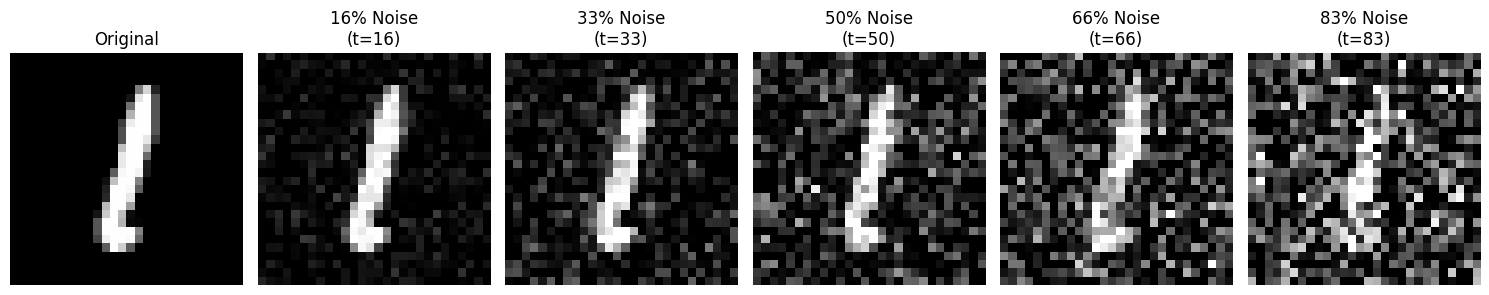

In [4]:
# Step 4: Set up diffusion schedule and noise functions
n_steps = 100              # number of diffusion timesteps
beta_start = 0.0001
beta_end = 0.02
beta = torch.linspace(beta_start, beta_end, n_steps).to(device)
alpha = 1.0 - beta
alpha_bar = torch.cumprod(alpha, dim=0)
sqrt_alpha_bar = torch.sqrt(alpha_bar)
sqrt_one_minus_alpha_bar = torch.sqrt(1.0 - alpha_bar)
print(f"Using linear noise schedule with {n_steps} steps, beta[0]={beta[0]:.4f}, beta[-1]={beta[-1]:.4f}")

def add_noise(x0, t):
    """
    Forward diffusion: add noise to clean image x0 at timestep t.
    Returns x_t and the sampled noise.
    """
    t = t.long()
    noise = torch.randn_like(x0)
    # Broadcast sqrt(alpha_bar[t]) and sqrt(1 - alpha_bar[t])
    sqrt_ab_t = sqrt_alpha_bar[t].view(-1, 1, 1, 1).to(device)
    sqrt_one_minus_ab_t = sqrt_one_minus_alpha_bar[t].view(-1, 1, 1, 1).to(device)
    # Diffusion q(x_t | x_0)
    x_t = sqrt_ab_t * x0 + sqrt_one_minus_ab_t * noise
    return x_t, noise

@torch.no_grad()
def remove_noise(x_t, t, model, c, c_mask):
    """
    Reverse diffusion: one step of denoising from x_t to x_{t-1} using the model.
    """
    t = t.long()
    # Predict noise epsilon at this timestep
    pred_noise = model(x_t, t, c, c_mask)
    # Gather coefficients for this timestep
    alpha_t = alpha[t].view(-1, 1, 1, 1).to(device)
    beta_t = beta[t].view(-1, 1, 1, 1).to(device)
    sqrt_one_minus_ab_t = sqrt_one_minus_alpha_bar[t].view(-1, 1, 1, 1).to(device)
    # Compute the mean of q(x_{t-1} | x_t, x0) (DDPM formula)
    mean = (1.0 / torch.sqrt(alpha_t)) * (x_t - (beta_t / (sqrt_one_minus_ab_t + 1e-9)) * pred_noise)
    # Sample x_{t-1} by adding noise (except for t=0)
    if (t > 0).any():
        noise = torch.randn_like(x_t)
    else:
        noise = torch.zeros_like(x_t)
    sigma = torch.sqrt(beta_t)
    x_prev = mean + sigma * noise
    return x_prev

# Visualization: show how an image becomes noisy over time
def show_noise_progression(image, num_steps=5):
    """Visualize a clean image gradually being noised."""
    img = image.to(device)
    plt.figure(figsize=(15,3))
    # Original image
    plt.subplot(1, num_steps+1, 1)
    plt.axis("off")
    plt.title("Original")
    if IMG_CH == 1:
        plt.imshow(to_image(img)[0].cpu(), cmap="gray")
    else:
        plt.imshow(to_image(img).permute(1,2,0).cpu())
    # Intermediate noise levels
    for i in range(1, num_steps+1):
        t_idx = int(i * n_steps / (num_steps + 1))
        t_idx = max(0, min(n_steps-1, t_idx))
        noisy_img, _ = add_noise(img.unsqueeze(0), torch.tensor([t_idx]).to(device))
        noisy_img = noisy_img.squeeze(0)
        plt.subplot(1, num_steps+1, i+1)
        plt.axis("off")
        plt.title(f"{(t_idx/n_steps)*100:.0f}% Noise\n(t={t_idx})")
        if IMG_CH == 1:
            plt.imshow(to_image(noisy_img)[0].cpu(), cmap="gray")
        else:
            plt.imshow(to_image(noisy_img).permute(1,2,0).cpu())
    plt.tight_layout()
    plt.show()

# Demonstrate noise addition on a sample image
try:
    sample_img, sample_label = next(iter(train_loader))
    sample_img = sample_img[0]  # take one image from the batch
    print("Showing noise progression on a sample image:")
    show_noise_progression(sample_img, num_steps=5)
except Exception as e:
    print(f"Could not show noise progression: {e}")


In [5]:
# Step 5: Instantiate model, optimizer, and define training utilities
# Model instantiation (U-Net)
unet_down_chs = (32, 64, 128)   # channel sizes for each level
unet_t_embed_dim = 8           # dimensionality of time embedding
unet_c_embed_dim = N_CLASSES   # number of classes (for class embedding)
model = UNet(T=n_steps, img_ch=IMG_CH, img_size=IMG_SIZE,
             down_chs=unet_down_chs, t_embed_dim=unet_t_embed_dim, c_embed_dim=unet_c_embed_dim).to(device)
print(f"✓ UNet model instantiated on {device} with {sum(p.numel() for p in model.parameters()):,} parameters.")

# Optimizer and learning rate scheduler
initial_lr = 1e-3
weight_decay = 1e-5
optimizer = Adam(model.parameters(), lr=initial_lr, weight_decay=weight_decay)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True, min_lr=1e-6)
print(f"Optimizer: Adam (lr={initial_lr}, weight_decay={weight_decay}) with ReduceLROnPlateau scheduler.")

# Training configuration
early_stopping_patience = 10
gradient_clip_value = 1.0
display_frequency = 100         # log training loss every 100 steps
generate_frequency = 500        # generate samples during training every 500 steps
epoch_generate_frequency = 2    # generate samples at end of every 2 epochs
epoch_plot_frequency = 5        # plot loss curves every 5 epochs

# Helper functions for monitoring and saving
def validate_model_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total params: {total_params:,}, Trainable: {trainable_params:,}")
    est_mem = (total_params * 4 * 3) / (1024**2)  # 4 bytes each, param+grad+buffer
    print(f"Estimated model memory usage: ~{est_mem:.1f} MB")

def verify_data_range(dataloader, name="Dataset"):
    try:
        batch = next(iter(dataloader))[0]
        print(f"{name} data range: min={batch.min().item():.2f}, max={batch.max().item():.2f}, dtype={batch.dtype}")
    except Exception as e:
        print(f"Could not verify data range for {name}: {e}")

@torch.no_grad()
def generate_samples(model, n_samples=10):
    """Generate sample images (one per class if n_samples>=N_CLASSES) without CFG."""
    model.eval()
    samples = []
    num = min(n_samples, N_CLASSES)
    for digit in range(num):
        x = torch.randn(1, IMG_CH, IMG_SIZE, IMG_SIZE).to(device)
        c = torch.tensor([digit], dtype=torch.long).to(device)
        c_one_hot = F.one_hot(c, N_CLASSES).float().to(device)
        c_mask = torch.ones(1, dtype=torch.bool, device=device)
        # Reverse diffusion from x_T to x_0
        for t in range(n_steps-1, -1, -1):
            t_batch = torch.full((1,), t, dtype=torch.long).to(device)
            x = remove_noise(x, t_batch, model, c_one_hot, c_mask)
        samples.append(x)
    samples = torch.cat(samples, dim=0)
    samples = to_image(samples)  # un-normalize for display
    grid_img = make_grid(samples, nrow=min(num, 5))
    plt.figure(figsize=(10, 2 if num <=5 else 4))
    plt.imshow(grid_img[0].cpu(), cmap='gray')
    plt.axis("off")
    plt.title("Generated Samples (no CFG)")
    plt.show()
    model.train()

def safe_save_model(model, path, optimizer=None, epoch=None, best_loss=None):
    """Save model state to disk with backup."""
    try:
        if os.path.exists(path):
            os.replace(path, path + ".backup")  # backup old file
        save_dict = {'model_state_dict': model.state_dict()}
        if optimizer is not None:
            save_dict['optimizer_state_dict'] = optimizer.state_dict()
        if epoch is not None:
            save_dict['epoch'] = epoch
        if best_loss is not None:
            save_dict['best_loss'] = best_loss
        torch.save(save_dict, path)
        print(f"Model saved to {path}")
    except Exception as e:
        print(f"Error saving model: {e}")

# Display model and data info for verification
validate_model_parameters(model)
verify_data_range(train_loader, "Training")
verify_data_range(val_loader, "Validation")


✓ UNet model instantiated on cuda with 1,573,121 parameters.
Optimizer: Adam (lr=0.001, weight_decay=1e-05) with ReduceLROnPlateau scheduler.
Total params: 1,573,121, Trainable: 1,573,121
Estimated model memory usage: ~18.0 MB


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training data range: min=-1.00, max=1.00, dtype=torch.float32
Validation data range: min=-1.00, max=1.00, dtype=torch.float32



===== Starting Training =====
Epochs: 20, Batch size: 128, Diffusion steps: 100, Device: cuda

--- Epoch 1/20 ---


Training Epoch 1:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 1 Training Loss: 0.1131
Epoch 1 Validation Loss: 0.0782
Model saved to best_model_mnist.pth

--- Epoch 2/20 ---


Training Epoch 2:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 2 Training Loss: 0.0743
Epoch 2 Validation Loss: 0.0716
Model saved to best_model_mnist.pth
Generating samples at end of epoch 2...


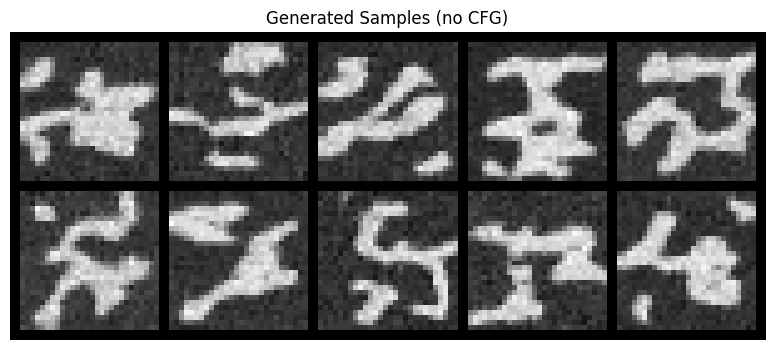


--- Epoch 3/20 ---


Training Epoch 3:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 3 Training Loss: 0.0682
Epoch 3 Validation Loss: 0.0663
Model saved to best_model_mnist.pth

--- Epoch 4/20 ---


Training Epoch 4:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 4 Training Loss: 0.0647
Epoch 4 Validation Loss: 0.0636
Model saved to best_model_mnist.pth
Generating samples at end of epoch 4...


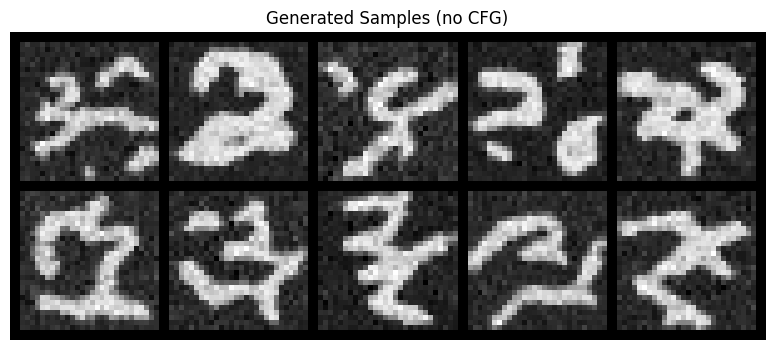


--- Epoch 5/20 ---


Training Epoch 5:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 5 Training Loss: 0.0632
Epoch 5 Validation Loss: 0.0619
Model saved to best_model_mnist.pth


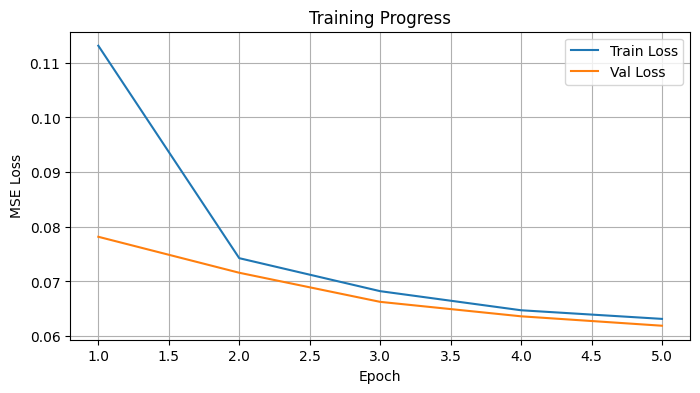


--- Epoch 6/20 ---


Training Epoch 6:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 6 Training Loss: 0.0614
Epoch 6 Validation Loss: 0.0611
Model saved to best_model_mnist.pth
Generating samples at end of epoch 6...


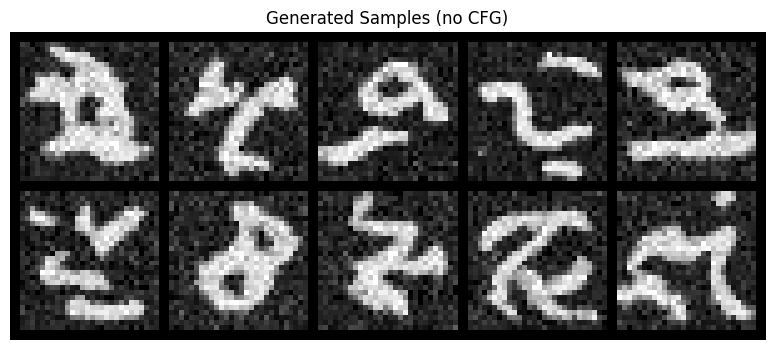


--- Epoch 7/20 ---


Training Epoch 7:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 7 Training Loss: 0.0604
Epoch 7 Validation Loss: 0.0604
Model saved to best_model_mnist.pth

--- Epoch 8/20 ---


Training Epoch 8:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 8 Training Loss: 0.0596
Epoch 8 Validation Loss: 0.0588
Model saved to best_model_mnist.pth
Generating samples at end of epoch 8...


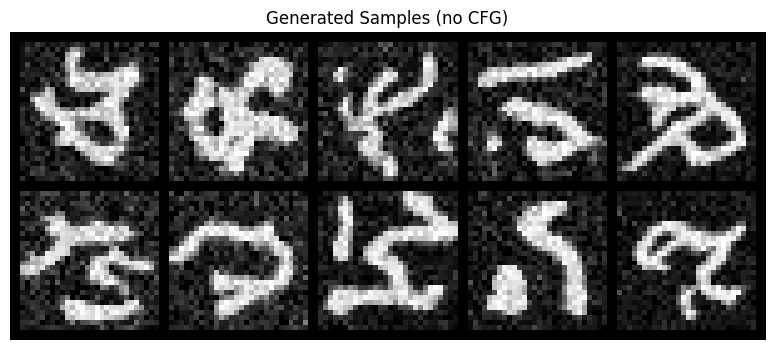


--- Epoch 9/20 ---


Training Epoch 9:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 9 Training Loss: 0.0589
Epoch 9 Validation Loss: 0.0590

--- Epoch 10/20 ---


Training Epoch 10:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 10 Training Loss: 0.0588
Epoch 10 Validation Loss: 0.0591
Generating samples at end of epoch 10...


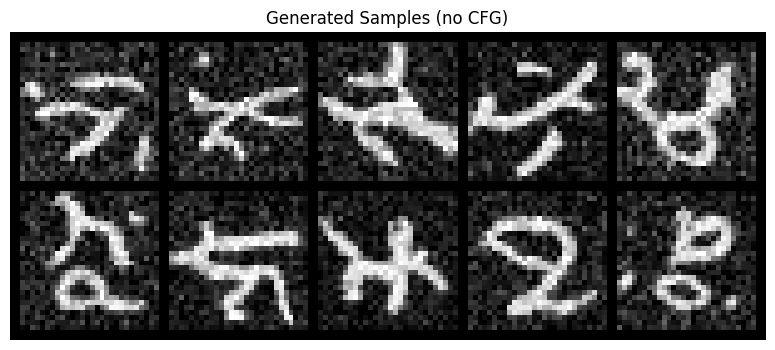

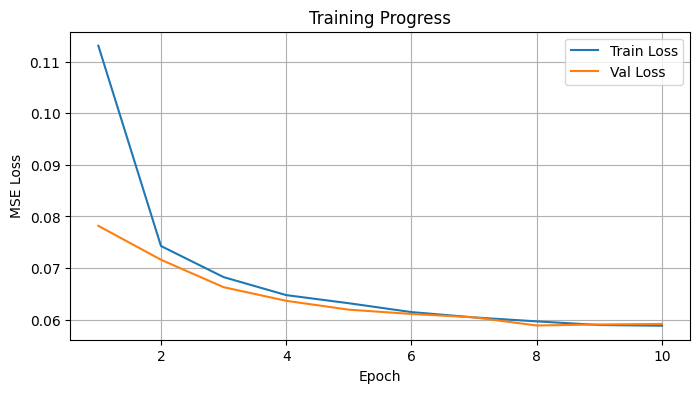


--- Epoch 11/20 ---


Training Epoch 11:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 11 Training Loss: 0.0581
Epoch 11 Validation Loss: 0.0585
Model saved to best_model_mnist.pth

--- Epoch 12/20 ---


Training Epoch 12:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 12 Training Loss: 0.0581
Epoch 12 Validation Loss: 0.0573
Model saved to best_model_mnist.pth
Generating samples at end of epoch 12...


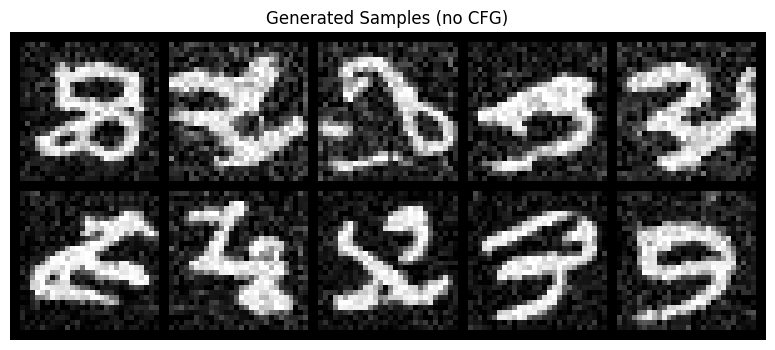


--- Epoch 13/20 ---


Training Epoch 13:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 13 Training Loss: 0.0578
Epoch 13 Validation Loss: 0.0565
Model saved to best_model_mnist.pth

--- Epoch 14/20 ---


Training Epoch 14:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 14 Training Loss: 0.0577
Epoch 14 Validation Loss: 0.0568
Generating samples at end of epoch 14...


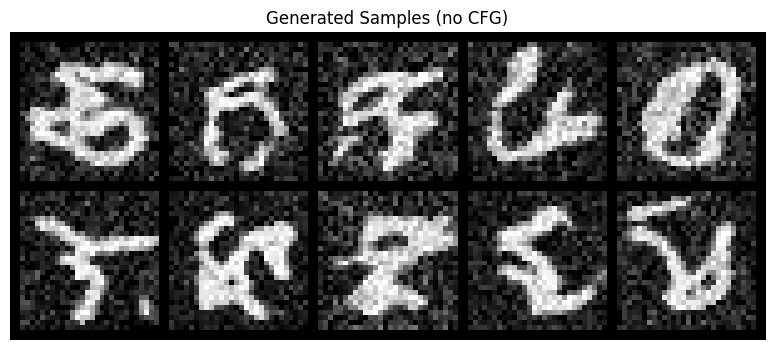


--- Epoch 15/20 ---


Training Epoch 15:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 15 Training Loss: 0.0573
Epoch 15 Validation Loss: 0.0574


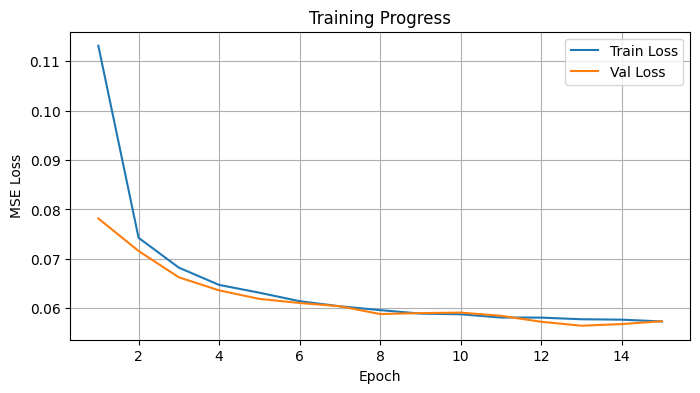


--- Epoch 16/20 ---


Training Epoch 16:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 16 Training Loss: 0.0573
Epoch 16 Validation Loss: 0.0569
Generating samples at end of epoch 16...


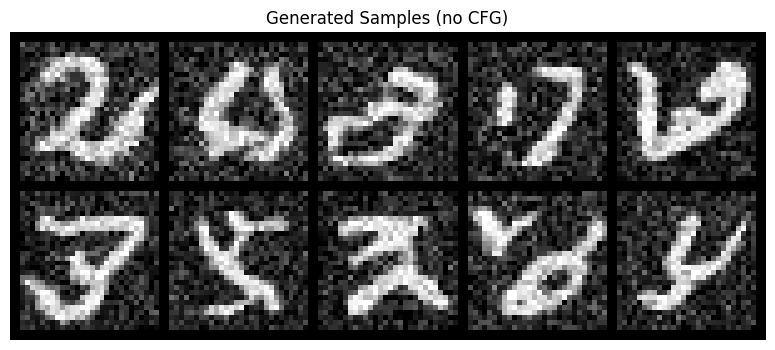


--- Epoch 17/20 ---


Training Epoch 17:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 17 Training Loss: 0.0569
Epoch 17 Validation Loss: 0.0561
Model saved to best_model_mnist.pth

--- Epoch 18/20 ---


Training Epoch 18:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 18 Training Loss: 0.0567
Epoch 18 Validation Loss: 0.0567
Generating samples at end of epoch 18...


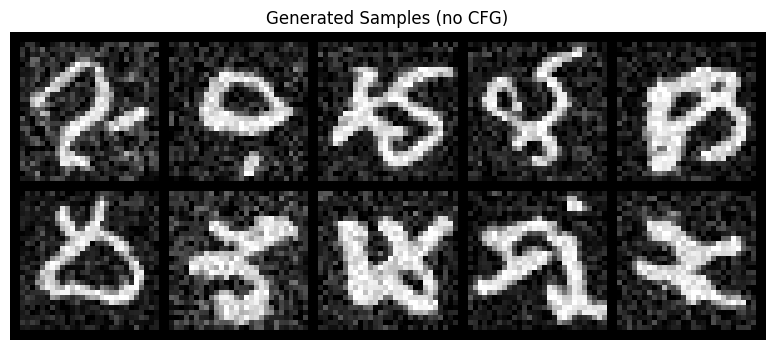


--- Epoch 19/20 ---


Training Epoch 19:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 19 Training Loss: 0.0569
Epoch 19 Validation Loss: 0.0563

--- Epoch 20/20 ---


Training Epoch 20:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 20 Training Loss: 0.0566
Epoch 20 Validation Loss: 0.0556
Model saved to best_model_mnist.pth
Generating samples at end of epoch 20...


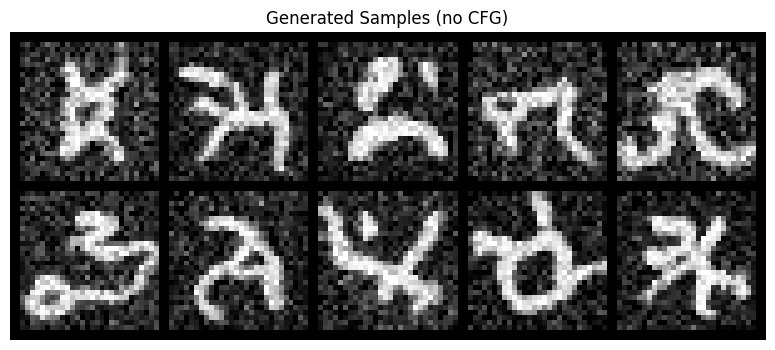

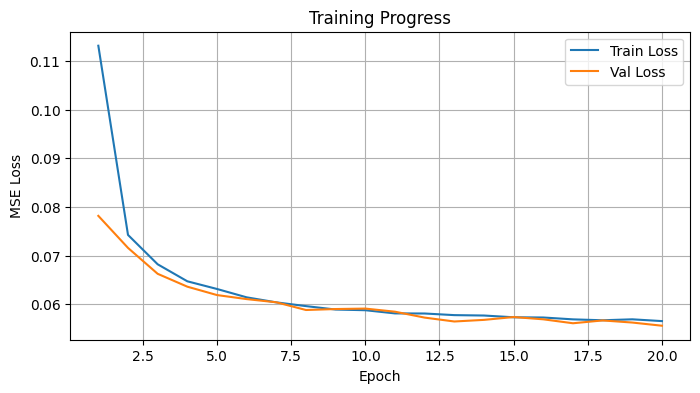


Training complete.
Best validation loss: 0.0556


In [6]:
# Step 5 (continued): Training loop
best_loss = float('inf')
train_losses = []
val_losses = []
no_improve_epochs = 0

print("\n===== Starting Training =====")
print(f"Epochs: {EPOCHS}, Batch size: {BATCH_SIZE}, Diffusion steps: {n_steps}, Device: {device}")
try:
    for epoch in range(EPOCHS):
        print(f"\n--- Epoch {epoch+1}/{EPOCHS} ---")
        model.train()
        epoch_train_losses = []
        pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Training Epoch {epoch+1}", leave=False)
        for step, (images, labels) in pbar:
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            # Sample random timestep for each image
            t = torch.randint(0, n_steps, (images.size(0),), device=device)
            # Forward diffusion (add noise)
            x_t, noise = add_noise(images, t)
            # Prepare class conditioning (one-hot) and mask (all True for conditioning)
            c_one_hot = F.one_hot(labels.long(), N_CLASSES).float().to(device)
            c_mask = torch.ones(labels.shape[0], dtype=torch.bool, device=device)
            # Predict noise from x_t
            pred_noise = model(x_t, t, c_one_hot, c_mask)
            loss = F.mse_loss(pred_noise, noise)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=gradient_clip_value)
            optimizer.step()
            epoch_train_losses.append(loss.item())
            if step % display_frequency == 0:
                pbar.set_postfix(loss=f"{loss.item():.4f}")
            # Mid-epoch generation for visual monitoring
            if generate_frequency and (step + 1) % generate_frequency == 0:
                print(f"\nGenerating samples at step {step+1}...")
                try:
                    generate_samples(model, n_samples=10)
                except Exception as e:
                    print(f"Error during sample generation: {e}")
                    model.train()
                model.train()
        avg_train_loss = np.mean(epoch_train_losses) if epoch_train_losses else 0.0
        train_losses.append(avg_train_loss)
        print(f"Epoch {epoch+1} Training Loss: {avg_train_loss:.4f}")
        # Validation
        model.eval()
        val_epoch_losses = []
        for val_images, val_labels in val_loader:
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)
            t = torch.randint(0, n_steps, (val_images.size(0),), device=device)
            x_t, noise = add_noise(val_images, t)
            c_one_hot = F.one_hot(val_labels.long(), N_CLASSES).float().to(device)
            c_mask = torch.ones(val_labels.size(0), dtype=torch.bool, device=device)
            pred_noise = model(x_t, t, c_one_hot, c_mask)
            val_loss = F.mse_loss(pred_noise, noise)
            val_epoch_losses.append(val_loss.item())
        avg_val_loss = np.mean(val_epoch_losses) if val_epoch_losses else float('inf')
        val_losses.append(avg_val_loss)
        print(f"Epoch {epoch+1} Validation Loss: {avg_val_loss:.4f}")
        # Learning rate scheduler step
        scheduler.step(avg_val_loss)
        # Check for best model
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            no_improve_epochs = 0
            safe_save_model(model, "best_model_mnist.pth", optimizer=optimizer, epoch=epoch+1, best_loss=best_loss)
        else:
            no_improve_epochs += 1
            if no_improve_epochs >= early_stopping_patience:
                print(f"No improvement for {no_improve_epochs} epochs. Early stopping triggered.")
                break
        # End-of-epoch sample generation
        if (epoch + 1) % epoch_generate_frequency == 0 or epoch == EPOCHS - 1:
            print(f"Generating samples at end of epoch {epoch+1}...")
            try:
                generate_samples(model, n_samples=10)
            except Exception as e:
                print(f"Error during end-of-epoch generation: {e}")
                model.train()
            model.train()
        # Plot loss curves periodically
        if (epoch + 1) % epoch_plot_frequency == 0 or epoch == EPOCHS - 1:
            if train_losses and val_losses:
                plt.figure(figsize=(8,4))
                plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
                plt.plot(range(1, len(val_losses)+1), val_losses, label="Val Loss")
                plt.xlabel("Epoch"); plt.ylabel("MSE Loss"); plt.title("Training Progress")
                plt.legend(); plt.grid(True); plt.show()
except KeyboardInterrupt:
    print("Training interrupted by user.")
except Exception as e:
    print(f"Error during training: {e}")
finally:
    print("\nTraining complete.")
    if val_losses:
        print(f"Best validation loss: {best_loss:.4f}")
    else:
        print("No validation data was evaluated.")


In [8]:
# Step 7: Visualizing the Generation Process (CFG)
@torch.no_grad()
def visualize_generation_steps(model, number, n_preview_steps=10, cfg_scale=3.0):
    """
    Show how a sample of `number` evolves from noise to a digit using CFG.
    """
    model.eval()
    x = torch.randn(1, IMG_CH, IMG_SIZE, IMG_SIZE).to(device)
    c = torch.tensor([number], dtype=torch.long).to(device)
    c_one_hot = F.one_hot(c, N_CLASSES).float().to(device)
    mask_cond = torch.ones(1, dtype=torch.bool, device=device)
    mask_uncond = torch.zeros(1, dtype=torch.bool, device=device)

    # choose timesteps to snapshot
    steps = torch.linspace(n_steps-1, 0, n_preview_steps).long().unique().tolist()
    images = [to_image(x.squeeze(0)).cpu()]

    for t in range(n_steps-1, -1, -1):
        t_batch = torch.full((1,), t, dtype=torch.long, device=device)
        eps_uncond = model(x, t_batch, c_one_hot, mask_uncond)
        eps_cond   = model(x, t_batch, c_one_hot, mask_cond)
        eps = eps_uncond + cfg_scale * (eps_cond - eps_uncond)
        eps = eps.clamp(-1.5, 1.5)
        alpha_t = alpha[t].view(1,1,1,1)
        beta_t  = beta[t].view(1,1,1,1)
        sqrt_ab = torch.sqrt(alpha_t)
        sqrt_omb = sqrt_one_minus_alpha_bar[t].view(1,1,1,1)
        mean = (1/sqrt_ab) * (x - (beta_t/(sqrt_omb+1e-9)) * eps)
        if t > 0:
            noise = torch.randn_like(x)
            x = mean + torch.sqrt(beta_t) * noise
        else:
            x = mean
        if t in steps:
            images.append(to_image(x.squeeze(0)).cpu())

    # plot progression
    plt.figure(figsize=(2*len(images), 2))
    for i, img in enumerate(images):
        plt.subplot(1, len(images), i+1)
        plt.imshow(img[0], cmap='gray')
        plt.title("t=%d" % (n_steps-1 if i==0 else steps[i-1]))
        plt.axis('off')
    plt.suptitle(f"Generation of digit {number}")
    plt.tight_layout()
    plt.show()

# Example usage:
visualize_generation_steps(model_to_use, number=5, n_preview_steps=8, cfg_scale=3.0)


NameError: name 'model_to_use' is not defined